# Comprehensive Policy Impact Analysis: Who is Most Affected?

This notebook analyzes who would be most affected by arxiv policies that:
1. **Restrict review/position papers** from being posted
2. **Flag AI-generated content**

We examine whether certain groups are disproportionately affected:
- **Junior researchers** (low h-index, fewer publications)
- **Authors from less prestigious institutions** (lower institutional h-index)
- **Authors from the Global South**
- **Intersectional effects** (multiple disadvantaged categories)

In [720]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

DATA_DIR = Path('../data')
OPENALEX_DIR = DATA_DIR / 'openalex'
RESULTS_DIR = DATA_DIR / 'results'
PROCESSED_DIR = DATA_DIR / 'processed'

## 0. OpenAlex Data Collection Report

Before analyzing the data, we first report on the data collection and enrichment process from OpenAlex.

### Data Collection Pipeline
The data collection involved three phases:
1. **Phase 1: Work-level enrichment** - Fetching paper metadata from OpenAlex using arXiv DOIs
2. **Phase 2: Author profile enrichment** - Fetching detailed author profiles (h-index, works count, etc.)
3. **Phase 3: Institution profile enrichment** - Fetching institutional metadata (h-index, country, type)

### Source Categories
Papers were collected from 10 CS subcategories on arXiv:
- cs-AI (Artificial Intelligence)
- cs-CL (Computation and Language)
- cs-CR (Cryptography and Security)
- cs-CV (Computer Vision)
- cs-CY (Computers and Society)
- cs-HC (Human-Computer Interaction)
- cs-IR (Information Retrieval)
- cs-LG (Machine Learning)
- cs-RO (Robotics)
- cs-SE (Software Engineering)

In [721]:
# Data Collection Report: Analyze OpenAlex enrichment coverage
print("=" * 70)
print("OPENALEX DATA COLLECTION REPORT")
print("=" * 70)

# Categories to analyze
cs_categories = ['cs-AI', 'cs-CL', 'cs-CR', 'cs-CV', 'cs-CY', 'cs-HC', 'cs-IR', 'cs-LG', 'cs-RO', 'cs-SE']

# 1. Count papers attempted from each category
print("\n1. SOURCE DATA BY CATEGORY")
print("-" * 50)

source_counts = {}
total_source = 0

for category in cs_categories:
    metadata_file = PROCESSED_DIR / category / 'paper_metadata.json'
    if metadata_file.exists():
        with open(metadata_file) as f:
            papers = json.load(f)
            source_counts[category] = len(papers)
            total_source += len(papers)
            print(f"  {category}: {len(papers):,} papers")
    else:
        source_counts[category] = 0
        print(f"  {category}: File not found")

print(f"\n  TOTAL SOURCE PAPERS: {total_source:,}")

OPENALEX DATA COLLECTION REPORT

1. SOURCE DATA BY CATEGORY
--------------------------------------------------
  cs-AI: 9,573 papers
  cs-CL: 24,323 papers
  cs-CR: 8,980 papers
  cs-CV: 34,835 papers
  cs-CY: 3,943 papers
  cs-HC: 7,402 papers
  cs-IR: 4,155 papers
  cs-LG: 22,455 papers
  cs-RO: 14,667 papers
  cs-SE: 7,911 papers

  TOTAL SOURCE PAPERS: 138,244


In [722]:
# 1b. Paper Type (Review) Classifications in Source Data
print("\n1b. PAPER TYPE CLASSIFICATIONS IN SOURCE DATA")
print("-" * 70)
print("Note: paper_type is from the original metadata; classifications are from LLM analysis")

# Collect paper_type from source metadata and classifications from CSV
source_type_stats = {}

print(f"\n{'Category':<10} {'Total':>8} {'Review':>8} {'Regular':>8} {'Unknown':>8} {'Rev %':>8}")
print("-" * 58)

total_review = 0
total_regular = 0
total_unknown = 0

for category in cs_categories:
    metadata_file = PROCESSED_DIR / category / 'paper_metadata.json'
    classification_file = PROCESSED_DIR / category / 'paper_classifications.csv'
    
    if metadata_file.exists():
        with open(metadata_file) as f:
            papers = json.load(f)
        
        # Count paper_type from original metadata
        type_counts = Counter(p.get('paper_type', 'unknown') for p in papers)
        n_review = type_counts.get('review', 0)
        n_regular = type_counts.get('regular', 0)
        n_unknown = type_counts.get('unknown', 0)
        n_total = len(papers)
        
        # If most are unknown, check if classifications exist
        if n_unknown > 0 and classification_file.exists():
            class_df = pd.read_csv(classification_file)
            n_classified = len(class_df)
            n_review_classified = (class_df['predicted_type'] == 'review').sum()
            n_regular_classified = (class_df['predicted_type'] == 'regular').sum()
            # Use classifications if available
            n_review = n_review_classified
            n_regular = n_regular_classified
            n_unknown = n_total - n_classified
        
        total_review += n_review
        total_regular += n_regular
        total_unknown += n_unknown
        
        # Calculate review percentage (of classified papers)
        n_classified = n_review + n_regular
        review_pct = (n_review / n_classified * 100) if n_classified > 0 else 0
        
        source_type_stats[category] = {
            'total': n_total,
            'review': n_review,
            'regular': n_regular,
            'unknown': n_unknown,
            'review_pct': review_pct
        }
        
        print(f"{category:<10} {n_total:>8,} {n_review:>8,} {n_regular:>8,} {n_unknown:>8,} {review_pct:>7.1f}%")

# Totals
total_classified = total_review + total_regular
overall_review_pct = (total_review / total_classified * 100) if total_classified > 0 else 0
print("-" * 58)
print(f"{'TOTAL':<10} {total_source:>8,} {total_review:>8,} {total_regular:>8,} {total_unknown:>8,} {overall_review_pct:>7.1f}%")

print(f"\nClassification coverage: {total_classified:,} of {total_source:,} papers ({total_classified/total_source*100:.1f}%)")
print(f"Papers missing classification: {total_unknown:,}")


1b. PAPER TYPE CLASSIFICATIONS IN SOURCE DATA
----------------------------------------------------------------------
Note: paper_type is from the original metadata; classifications are from LLM analysis

Category      Total   Review  Regular  Unknown    Rev %
----------------------------------------------------------
cs-AI         9,573    1,357    8,213        0    14.2%
cs-CL        24,323    2,243   22,062        0     9.2%
cs-CR         8,980    1,477    7,499        0    16.5%
cs-CV        34,835    1,021   33,804        0     2.9%
cs-CY         3,943    1,873    2,065        0    47.6%
cs-HC         7,402    1,785    5,614        0    24.1%
cs-IR         4,155      544    3,609        0    13.1%
cs-LG        22,455    1,390   21,056        0     6.2%
cs-RO        14,667      507   14,159        0     3.5%
cs-SE         7,911    1,948    5,960        0    24.6%
----------------------------------------------------------
TOTAL       138,244   14,145  124,041        0    10.2%

Clas

In [ ]:
# 1c. Pangram AI Detection Coverage
print("\n1c. PANGRAM AI DETECTION COVERAGE BY CATEGORY")
print("-" * 70)
print("Note: AI detection was run on a subset of papers using the Pangram API")

# Load Pangram results from each category
pangram_stats = {}
total_pangram = 0
total_ai_flagged = 0

print(f"\n{'Category':<10} {'Source':>8} {'Pangram':>10} {'Coverage':>10} {'AI Flag':>10} {'AI %':>8}")
print("-" * 62)

for category in cs_categories:
    results_file = RESULTS_DIR / category / 'pangram_detection_results.json'
    source = source_counts.get(category, 0)
    
    if results_file.exists():
        with open(results_file) as f:
            results = json.load(f)
        
        n_pangram = len(results)
        # Count papers flagged as AI (likelihood > 0.5)
        n_ai_flagged = sum(1 for p in results 
                          if p.get('pangram_prediction', {}).get('ai_likelihood', 0) > 0.5)
        coverage = (n_pangram / source * 100) if source > 0 else 0
        ai_pct = (n_ai_flagged / n_pangram * 100) if n_pangram > 0 else 0
        
        pangram_stats[category] = {
            'source': source,
            'pangram': n_pangram,
            'coverage': coverage,
            'ai_flagged': n_ai_flagged,
            'ai_pct': ai_pct
        }
        total_pangram += n_pangram
        total_ai_flagged += n_ai_flagged
        
        print(f"{category:<10} {source:>8,} {n_pangram:>10,} {coverage:>9.1f}% {n_ai_flagged:>10,} {ai_pct:>7.1f}%")
    else:
        print(f"{category:<10} {source:>8,} {'Not found':>10}")

# Totals
overall_coverage = (total_pangram / total_source * 100) if total_source > 0 else 0
overall_ai_pct = (total_ai_flagged / total_pangram * 100) if total_pangram > 0 else 0
print("-" * 62)
print(f"{'TOTAL':<10} {total_source:>8,} {total_pangram:>10,} {overall_coverage:>9.1f}% {total_ai_flagged:>10,} {overall_ai_pct:>7.1f}%")

print(f"\nPangram detection coverage: {total_pangram:,} of {total_source:,} source papers ({overall_coverage:.1f}%)")
print(f"Papers flagged as AI-generated (>50% likelihood): {total_ai_flagged:,} ({overall_ai_pct:.1f}% of analyzed)")




1c. PANGRAM AI DETECTION COVERAGE BY CATEGORY
----------------------------------------------------------------------
Note: AI detection was run on a subset of papers using the Pangram API

Category     Source    Pangram   Coverage    AI Flag     AI %
--------------------------------------------------------------
cs-AI         9,573      3,498      36.5%        453    13.0%
cs-CL        24,323      3,600      14.8%        316     8.8%
cs-CR         8,980      3,548      39.5%        489    13.8%
cs-CV        34,835      3,600      10.3%        253     7.0%
cs-CY         3,943      2,308      58.5%        466    20.2%
cs-HC         7,402      3,437      46.4%        388    11.3%
cs-IR         4,155      2,700      65.0%        210     7.8%
cs-LG        22,455      3,600      16.0%        356     9.9%
cs-RO        14,667      3,600      24.5%        240     6.7%
cs-SE         7,911      3,522      44.5%        374    10.6%
--------------------------------------------------------------
TO

In [724]:
# 2. Load enriched works and analyze coverage by category (enriched = the paper was found on OpenAlex)
print("\n2. OPENALEX ENRICHMENT COVERAGE BY CATEGORY")
print("-" * 50)

with open(OPENALEX_DIR / 'works_enriched.json') as f:
    works_enriched = json.load(f)

# Count enriched papers by category
enriched_by_category = Counter()
for arxiv_id, work in works_enriched.items():
    category = work.get('category', 'unknown')
    enriched_by_category[category] += 1

# Calculate coverage rates
print(f"{'Category':<12} {'Source':>10} {'Enriched':>10} {'Coverage':>10}")
print("-" * 45)

total_enriched = 0
for category in cs_categories:
    source = source_counts.get(category, 0)
    enriched = enriched_by_category.get(category, 0)
    coverage = (enriched / source * 100) if source > 0 else 0
    total_enriched += enriched
    print(f"{category:<12} {source:>10,} {enriched:>10,} {coverage:>9.1f}%")

overall_coverage = (total_enriched / total_source * 100) if total_source > 0 else 0
print("-" * 45)
print(f"{'TOTAL':<12} {total_source:>10,} {total_enriched:>10,} {overall_coverage:>9.1f}%")


2. OPENALEX ENRICHMENT COVERAGE BY CATEGORY
--------------------------------------------------
Category         Source   Enriched   Coverage
---------------------------------------------
cs-AI             9,573      7,012      73.2%
cs-CL            24,323     18,772      77.2%
cs-CR             8,980      6,317      70.3%
cs-CV            34,835     26,628      76.4%
cs-CY             3,943      2,744      69.6%
cs-HC             7,402      4,619      62.4%
cs-IR             4,155      2,791      67.2%
cs-LG            22,455     17,684      78.8%
cs-RO            14,667     10,719      73.1%
cs-SE             7,911      5,161      65.2%
---------------------------------------------
TOTAL           138,244    102,447      74.1%


In [725]:
# 3. Analyze what data was enriched
print("\n3. ENRICHMENT DATA QUALITY REPORT")
print("-" * 50)

# Count papers with various enrichment fields
has_topics = 0
has_keywords = 0
has_authorships = 0
has_citations = 0
has_primary_topic = 0
has_paper_type = 0

authorships_total = 0
institutions_total = 0

for arxiv_id, work in works_enriched.items():
    if work.get('topics') and len(work['topics']) > 0:
        has_topics += 1
    if work.get('keywords') and len(work['keywords']) > 0:
        has_keywords += 1
    if work.get('authorships') and len(work['authorships']) > 0:
        has_authorships += 1
        authorships_total += len(work['authorships'])
        for auth in work['authorships']:
            if auth.get('institution_ids'):
                institutions_total += len(auth['institution_ids'])
    if work.get('cited_by_count', 0) > 0:
        has_citations += 1
    if work.get('primary_topic'):
        has_primary_topic += 1
    if work.get('paper_type') and work['paper_type'] != 'unknown':
        has_paper_type += 1

n = len(works_enriched)
print(f"Papers with OpenAlex topics:       {has_topics:>8,} ({has_topics/n*100:>5.1f}%)")
print(f"Papers with OpenAlex keywords:     {has_keywords:>8,} ({has_keywords/n*100:>5.1f}%)")
print(f"Papers with authorship data:       {has_authorships:>8,} ({has_authorships/n*100:>5.1f}%)")
print(f"Papers with citation counts > 0:   {has_citations:>8,} ({has_citations/n*100:>5.1f}%)")
print(f"Papers with primary topic:         {has_primary_topic:>8,} ({has_primary_topic/n*100:>5.1f}%)")
print(f"Papers with known paper_type:      {has_paper_type:>8,} ({has_paper_type/n*100:>5.1f}%)")
print(f"\nTotal author-paper links:          {authorships_total:>8,}")
print(f"Total institution-author links:    {institutions_total:>8,}")


3. ENRICHMENT DATA QUALITY REPORT
--------------------------------------------------
Papers with OpenAlex topics:         91,040 ( 88.9%)
Papers with OpenAlex keywords:       86,050 ( 84.0%)
Papers with authorship data:        102,401 (100.0%)
Papers with citation counts > 0:     38,350 ( 37.4%)
Papers with primary topic:           91,040 ( 88.9%)
Papers with known paper_type:        25,117 ( 24.5%)

Total author-paper links:           474,740
Total institution-author links:      41,859


In [726]:
# 4. Author and Institution profile coverage
print("\n4. AUTHOR & INSTITUTION PROFILE ENRICHMENT")
print("-" * 50)

# Load author profiles
author_profiles_data = {}
with open(OPENALEX_DIR / 'author_profiles.jsonl') as f:
    for line in f:
        profile = json.loads(line.strip())
        author_profiles_data[profile['author_id']] = profile

# Load institution profiles
with open(OPENALEX_DIR / 'institution_profiles.json') as f:
    institution_profiles_data = json.load(f)

# Collect unique authors and institutions from works
unique_authors_in_works = set()
unique_institutions_in_works = set()

for work in works_enriched.values():
    for auth in work.get('authorships', []):
        if auth.get('author_id'):
            unique_authors_in_works.add(auth['author_id'])
        for inst_id in auth.get('institution_ids', []):
            if inst_id:
                unique_institutions_in_works.add(inst_id)

# Calculate coverage
authors_with_profiles = len([a for a in unique_authors_in_works if a in author_profiles_data])
institutions_with_profiles = len([i for i in unique_institutions_in_works if i in institution_profiles_data])

print(f"Unique authors in works:           {len(unique_authors_in_works):>8,}")
print(f"Authors with fetched profiles:     {authors_with_profiles:>8,} ({authors_with_profiles/len(unique_authors_in_works)*100:.1f}%)")
print(f"\nUnique institutions in works:      {len(unique_institutions_in_works):>8,}")
print(f"Institutions with fetched profiles:{institutions_with_profiles:>8,} ({institutions_with_profiles/len(unique_institutions_in_works)*100:.1f}%)")


4. AUTHOR & INSTITUTION PROFILE ENRICHMENT
--------------------------------------------------


Unique authors in works:            244,345
Authors with fetched profiles:      244,345 (100.0%)

Unique institutions in works:         3,063
Institutions with fetched profiles:   3,063 (100.0%)


In [727]:
# 5. Author profile data quality
print("\n5. AUTHOR PROFILE DATA QUALITY")
print("-" * 50)

has_h_index = 0
has_works_count = 0
has_cited_by = 0
has_2yr_mean_citedness = 0

h_indices = []
works_counts = []

for profile in author_profiles_data.values():
    if profile.get('h_index') is not None:
        has_h_index += 1
        h_indices.append(profile['h_index'])
    if profile.get('works_count') is not None:
        has_works_count += 1
        works_counts.append(profile['works_count'])
    if profile.get('cited_by_count') is not None:
        has_cited_by += 1
    if profile.get('summary_stats', {}).get('2yr_mean_citedness') is not None:
        has_2yr_mean_citedness += 1

n_authors = len(author_profiles_data)
print(f"Authors with h-index:              {has_h_index:>8,} ({has_h_index/n_authors*100:.1f}%)")
print(f"Authors with works_count:          {has_works_count:>8,} ({has_works_count/n_authors*100:.1f}%)")
print(f"Authors with cited_by_count:       {has_cited_by:>8,} ({has_cited_by/n_authors*100:.1f}%)")
print(f"Authors with 2yr_mean_citedness:   {has_2yr_mean_citedness:>8,} ({has_2yr_mean_citedness/n_authors*100:.1f}%)")

if h_indices:
    print(f"\nH-index distribution:")
    print(f"  Mean: {np.mean(h_indices):.1f}, Median: {np.median(h_indices):.1f}, Max: {max(h_indices)}")
if works_counts:
    print(f"\nWorks count distribution:")
    print(f"  Mean: {np.mean(works_counts):.1f}, Median: {np.median(works_counts):.1f}, Max: {max(works_counts)}")


5. AUTHOR PROFILE DATA QUALITY
--------------------------------------------------
Authors with h-index:               235,141 (96.2%)
Authors with works_count:           235,141 (96.2%)
Authors with cited_by_count:        235,141 (96.2%)
Authors with 2yr_mean_citedness:          0 (0.0%)

H-index distribution:
  Mean: 12.5, Median: 7.0, Max: 316

Works count distribution:
  Mean: 82.8, Median: 29.0, Max: 31838


In [728]:
# 6. Institution profile data quality
print("\n6. INSTITUTION PROFILE DATA QUALITY")
print("-" * 50)

has_inst_h_index = 0
has_country = 0
has_type = 0

inst_h_indices = []
countries = Counter()
inst_types = Counter()

for profile in institution_profiles_data.values():
    if profile.get('h_index') is not None:
        has_inst_h_index += 1
        inst_h_indices.append(profile['h_index'])
    if profile.get('country_code'):
        has_country += 1
        countries[profile['country_code']] += 1
    if profile.get('type'):
        has_type += 1
        inst_types[profile['type']] += 1

n_inst = len(institution_profiles_data)
print(f"Institutions with h-index:         {has_inst_h_index:>8,} ({has_inst_h_index/n_inst*100:.1f}%)")
print(f"Institutions with country:         {has_country:>8,} ({has_country/n_inst*100:.1f}%)")
print(f"Institutions with type:            {has_type:>8,} ({has_type/n_inst*100:.1f}%)")

if inst_h_indices:
    print(f"\nInstitutional h-index distribution:")
    print(f"  Mean: {np.mean(inst_h_indices):.1f}, Median: {np.median(inst_h_indices):.1f}, Max: {max(inst_h_indices)}")

print(f"\nTop 10 countries by institution count:")
for country, count in countries.most_common(10):
    print(f"  {country}: {count}")

print(f"\nInstitution types:")
for inst_type, count in inst_types.most_common():
    print(f"  {inst_type}: {count}")


6. INSTITUTION PROFILE DATA QUALITY
--------------------------------------------------
Institutions with h-index:            3,011 (98.3%)
Institutions with country:            2,909 (95.0%)
Institutions with type:               3,010 (98.3%)

Institutional h-index distribution:
  Mean: 308.1, Median: 203.0, Max: 3316

Top 10 countries by institution count:
  US: 588
  FR: 371
  CN: 311
  DE: 181
  GB: 142
  JP: 99
  CA: 84
  IN: 75
  IT: 69
  ES: 59

Institution types:
  education: 1715
  facility: 484
  company: 383
  other: 137
  healthcare: 136
  nonprofit: 88
  government: 60
  archive: 7


In [729]:
# 7. SANITY CHECK: Top and Bottom Entities by Key Metrics
print("\n7. SANITY CHECK: TOP AND BOTTOM ENTITIES BY KEY METRICS")
print("=" * 70)

# Helper function to print top/bottom
def print_top_bottom(data, key, name_key, entity_type, n=5):
    """Print top and bottom n entities by a given metric."""
    # Filter out None/missing values and create list of (name, value)
    valid = [(d.get(name_key, d.get('author_id', d.get('institution_id', 'Unknown'))), d.get(key, 0) or 0) 
             for d in data if d.get(key) is not None]
    if not valid:
        print(f"  No valid data for {key}")
        return
    
    sorted_data = sorted(valid, key=lambda x: x[1], reverse=True)
    
    print(f"\n  Top {n} {entity_type} by {key}:")
    for name, val in sorted_data[:n]:
        print(f"    {name[:50]:<50} {val:>10,}")
    
    print(f"\n  Bottom {n} {entity_type} by {key} (excluding zeros):")
    non_zero = [(name, val) for name, val in sorted_data if val > 0]
    for name, val in non_zero[-n:]:
        print(f"    {name[:50]:<50} {val:>10,}")

# === INSTITUTIONS ===
print("\n" + "-" * 70)
print("INSTITUTIONS")
print("-" * 70)

inst_list = list(institution_profiles_data.values())

# H-index
print_top_bottom(inst_list, 'h_index', 'display_name', 'institutions')

# Cited by count
print_top_bottom(inst_list, 'cited_by_count', 'display_name', 'institutions')

# Works count
print_top_bottom(inst_list, 'works_count', 'display_name', 'institutions')

# === AUTHORS ===
print("\n" + "-" * 70)
print("AUTHORS")
print("-" * 70)

author_list = list(author_profiles_data.values())

# H-index
print_top_bottom(author_list, 'h_index', 'display_name', 'authors')

# Cited by count
print_top_bottom(author_list, 'cited_by_count', 'display_name', 'authors')

# Works count
print_top_bottom(author_list, 'works_count', 'display_name', 'authors')

# i10-index (authors)
print_top_bottom(author_list, 'i10_index', 'display_name', 'authors')

print("\n" + "=" * 70)
print("Sanity check complete. Review above for any anomalous values.")


7. SANITY CHECK: TOP AND BOTTOM ENTITIES BY KEY METRICS

----------------------------------------------------------------------
INSTITUTIONS
----------------------------------------------------------------------

  Top 5 institutions by h_index:
    University of Washington                                3,316
    Harvard University                                      2,572
    National Institutes of Health                           2,399
    Stanford University                                     2,320
    Centre National de la Recherche Scientifique            2,278

  Bottom 5 institutions by h_index (excluding zeros):
    Amnesty International Ireland                               3
    Armée de l'air et de l'espace                               2
    International Project Management, Plating and Mate          2
    Aarno Labs                                                  1
    Korea Association of Information Systems                    1

  Top 5 institutions by cited_by_coun


8. SANITY CHECK: DISTRIBUTION HISTOGRAMS


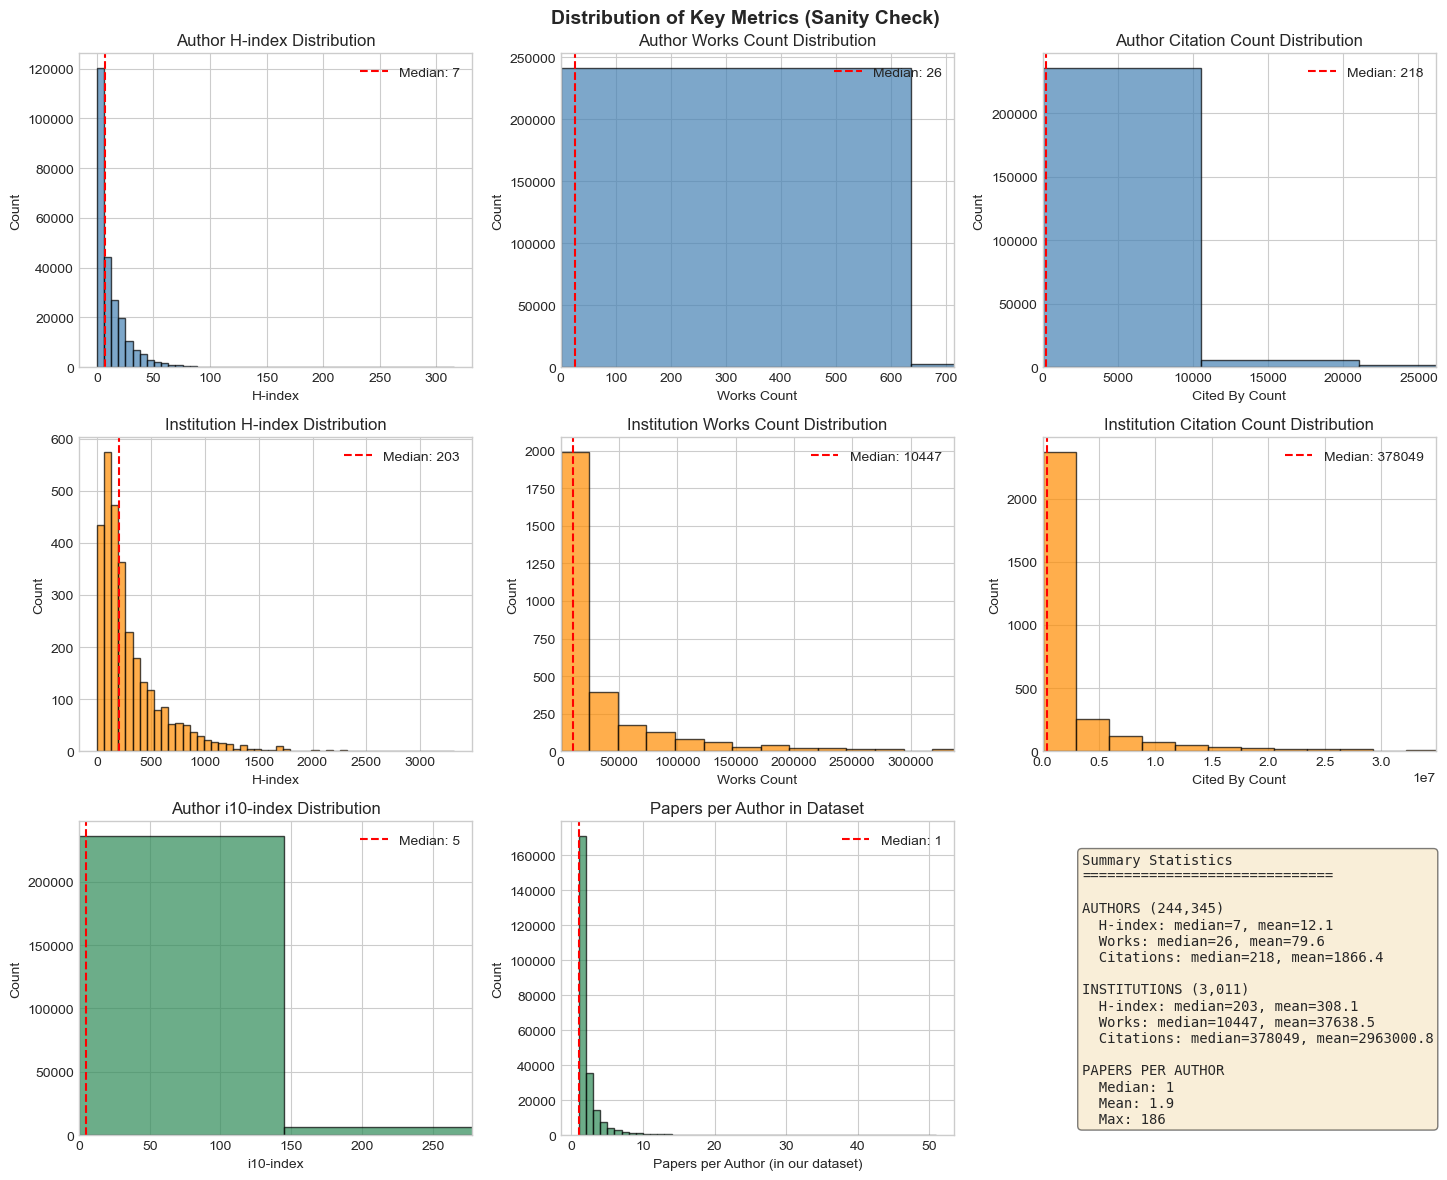


Histograms saved to ../figures/sanity_check_distributions.png


In [730]:
# 8. SANITY CHECK: Distribution Histograms
print("\n8. SANITY CHECK: DISTRIBUTION HISTOGRAMS")
print("=" * 70)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Distribution of Key Metrics (Sanity Check)', fontsize=14, fontweight='bold')

# Extract data
author_h_indices = [p.get('h_index', 0) or 0 for p in author_profiles_data.values()]
author_works = [p.get('works_count', 0) or 0 for p in author_profiles_data.values()]
author_citations = [p.get('cited_by_count', 0) or 0 for p in author_profiles_data.values()]
author_i10 = [p.get('i10_index', 0) or 0 for p in author_profiles_data.values()]

inst_h_indices = [p.get('h_index', 0) or 0 for p in institution_profiles_data.values() if not p.get('not_found')]
inst_works = [p.get('works_count', 0) or 0 for p in institution_profiles_data.values() if not p.get('not_found')]
inst_citations = [p.get('cited_by_count', 0) or 0 for p in institution_profiles_data.values() if not p.get('not_found')]

# Count papers per author in our dataset
papers_per_author = Counter()
for work in works_enriched.values():
    for auth in work.get('authorships', []):
        if auth.get('author_id'):
            papers_per_author[auth['author_id']] += 1
papers_per_author_list = list(papers_per_author.values())

# Row 1: Author metrics
ax = axes[0, 0]
ax.hist(author_h_indices, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('H-index')
ax.set_ylabel('Count')
ax.set_title('Author H-index Distribution')
ax.axvline(np.median(author_h_indices), color='red', linestyle='--', label=f'Median: {np.median(author_h_indices):.0f}')
ax.legend()

ax = axes[0, 1]
ax.hist(author_works, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Works Count')
ax.set_ylabel('Count')
ax.set_title('Author Works Count Distribution')
ax.set_xlim(0, np.percentile(author_works, 99))  # Clip at 99th percentile for visibility
ax.axvline(np.median(author_works), color='red', linestyle='--', label=f'Median: {np.median(author_works):.0f}')
ax.legend()

ax = axes[0, 2]
ax.hist(author_citations, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Cited By Count')
ax.set_ylabel('Count')
ax.set_title('Author Citation Count Distribution')
ax.set_xlim(0, np.percentile(author_citations, 99))
ax.axvline(np.median(author_citations), color='red', linestyle='--', label=f'Median: {np.median(author_citations):.0f}')
ax.legend()

# Row 2: Institution metrics
ax = axes[1, 0]
ax.hist(inst_h_indices, bins=50, edgecolor='black', alpha=0.7, color='darkorange')
ax.set_xlabel('H-index')
ax.set_ylabel('Count')
ax.set_title('Institution H-index Distribution')
ax.axvline(np.median(inst_h_indices), color='red', linestyle='--', label=f'Median: {np.median(inst_h_indices):.0f}')
ax.legend()

ax = axes[1, 1]
ax.hist(inst_works, bins=50, edgecolor='black', alpha=0.7, color='darkorange')
ax.set_xlabel('Works Count')
ax.set_ylabel('Count')
ax.set_title('Institution Works Count Distribution')
ax.set_xlim(0, np.percentile(inst_works, 99))
ax.axvline(np.median(inst_works), color='red', linestyle='--', label=f'Median: {np.median(inst_works):.0f}')
ax.legend()

ax = axes[1, 2]
ax.hist(inst_citations, bins=50, edgecolor='black', alpha=0.7, color='darkorange')
ax.set_xlabel('Cited By Count')
ax.set_ylabel('Count')
ax.set_title('Institution Citation Count Distribution')
ax.set_xlim(0, np.percentile(inst_citations, 99))
ax.axvline(np.median(inst_citations), color='red', linestyle='--', label=f'Median: {np.median(inst_citations):.0f}')
ax.legend()

# Row 3: Additional metrics
ax = axes[2, 0]
ax.hist(author_i10, bins=50, edgecolor='black', alpha=0.7, color='seagreen')
ax.set_xlabel('i10-index')
ax.set_ylabel('Count')
ax.set_title('Author i10-index Distribution')
ax.set_xlim(0, np.percentile(author_i10, 99))
ax.axvline(np.median(author_i10), color='red', linestyle='--', label=f'Median: {np.median(author_i10):.0f}')
ax.legend()

ax = axes[2, 1]
ax.hist(papers_per_author_list, bins=range(1, min(max(papers_per_author_list)+2, 52)), edgecolor='black', alpha=0.7, color='seagreen')
ax.set_xlabel('Papers per Author (in our dataset)')
ax.set_ylabel('Count')
ax.set_title('Papers per Author in Dataset')
ax.axvline(np.median(papers_per_author_list), color='red', linestyle='--', label=f'Median: {np.median(papers_per_author_list):.0f}')
ax.legend()

# Summary stats in last panel
ax = axes[2, 2]
ax.axis('off')
summary_text = (
    f"Summary Statistics\n"
    f"{'='*30}\n\n"
    f"AUTHORS ({len(author_profiles_data):,})\n"
    f"  H-index: median={np.median(author_h_indices):.0f}, mean={np.mean(author_h_indices):.1f}\n"
    f"  Works: median={np.median(author_works):.0f}, mean={np.mean(author_works):.1f}\n"
    f"  Citations: median={np.median(author_citations):.0f}, mean={np.mean(author_citations):.1f}\n\n"
    f"INSTITUTIONS ({len(inst_h_indices):,})\n"
    f"  H-index: median={np.median(inst_h_indices):.0f}, mean={np.mean(inst_h_indices):.1f}\n"
    f"  Works: median={np.median(inst_works):.0f}, mean={np.mean(inst_works):.1f}\n"
    f"  Citations: median={np.median(inst_citations):.0f}, mean={np.mean(inst_citations):.1f}\n\n"
    f"PAPERS PER AUTHOR\n"
    f"  Median: {np.median(papers_per_author_list):.0f}\n"
    f"  Mean: {np.mean(papers_per_author_list):.1f}\n"
    f"  Max: {max(papers_per_author_list)}"
)
ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../figures/sanity_check_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nHistograms saved to ../figures/sanity_check_distributions.png")


9. PAPERS PER YEAR ANALYSIS

Year           Source   OpenAlex   Coverage
---------------------------------------------
2020           14,205      8,584      60.4%
2021           19,305     13,249      68.6%
2022           19,640     16,022      81.6%
2023           23,028     19,339      84.0%
2024           28,746     23,708      82.5%
2025           33,320     21,545      64.7%
---------------------------------------------
Total         138,244    102,447      74.1%


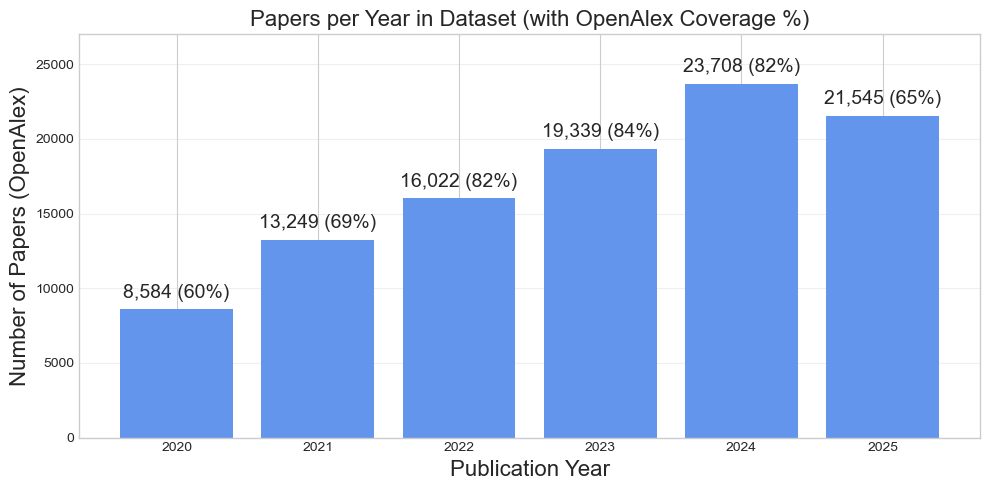


Chart saved to ../figures/papers_per_year.pdf
Note: Percentages show OpenAlex coverage (papers found on OpenAlex / original source papers)


In [735]:
# 9. PAPERS PER YEAR ANALYSIS
print("\n9. PAPERS PER YEAR ANALYSIS")
print("=" * 70)

# Count source papers per year from paper_metadata.json files
source_years = []
for category in cs_categories:
    metadata_file = PROCESSED_DIR / category / 'paper_metadata.json'
    if metadata_file.exists():
        with open(metadata_file) as f:
            papers = json.load(f)
        for p in papers:
            date = p.get('submission_date', '')
            if date and len(date) >= 4:
                source_years.append(int(date[:4]))

source_year_counts = Counter(source_years)

# Extract publication years from works_enriched (OpenAlex papers)
enriched_years = []
for work in works_enriched.values():
    year = work.get('publication_year')
    if year:
        enriched_years.append(year)

enriched_year_counts = Counter(enriched_years)

# Print table with coverage
print(f"\n{'Year':<10} {'Source':>10} {'OpenAlex':>10} {'Coverage':>10}")
print("-" * 45)
all_years = sorted(set(source_year_counts.keys()) | set(enriched_year_counts.keys()))
total_source_yr = sum(source_year_counts.values())
total_enriched_yr = sum(enriched_year_counts.values())
for year in all_years:
    source_ct = source_year_counts.get(year, 0)
    enriched_ct = enriched_year_counts.get(year, 0)
    coverage = (enriched_ct / source_ct * 100) if source_ct > 0 else 0
    print(f"{year:<10} {source_ct:>10,} {enriched_ct:>10,} {coverage:>9.1f}%")
print("-" * 45)
overall_cov = (total_enriched_yr / total_source_yr * 100) if total_source_yr > 0 else 0
print(f"{'Total':<10} {total_source_yr:>10,} {total_enriched_yr:>10,} {overall_cov:>9.1f}%")

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 5))

sorted_years = sorted(enriched_year_counts.keys())
counts = [enriched_year_counts[y] for y in sorted_years]

bars = ax.bar(sorted_years, counts, color='cornflowerblue')

# Add value labels on bars with OpenAlex coverage percentage
for bar, year in zip(bars, sorted_years):
    count = enriched_year_counts[year]
    source_ct = source_year_counts.get(year, 0)
    coverage = (count / source_ct * 100) if source_ct > 0 else 0
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
            f'{count:,} ({coverage:.0f}%)', ha='center', va='bottom', fontsize=14)

ax.set_ylim(0,27000)
ax.set_xlabel('Publication Year', fontsize=16)
ax.set_ylabel('Number of Papers (OpenAlex)', fontsize=16)
ax.set_title('Papers per Year in Dataset (with OpenAlex Coverage %)', fontsize=16)
ax.set_xticks(sorted_years)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/papers_per_year.pdf', bbox_inches='tight')
plt.show()

print(f"\nChart saved to ../figures/papers_per_year.pdf")
print(f"Note: Percentages show OpenAlex coverage (papers found on OpenAlex / original source papers)")


10. CS CATEGORY: REVIEW RATE VS AI-GENERATED RATE

Category     Papers   Review %       AI %
----------------------------------------
cs-AI         3,498      15.8%      13.0%
cs-CL         3,600       9.4%       8.8%
cs-CR         3,548      15.2%      13.8%
cs-CV         3,600       2.4%       7.0%
cs-CY         2,308      49.2%      20.2%
cs-HC         3,437      23.3%      11.3%
cs-IR         2,700      13.4%       7.8%
cs-LG         3,600       5.7%       9.9%
cs-RO         3,600       3.7%       6.7%
cs-SE         3,522      23.4%      10.6%


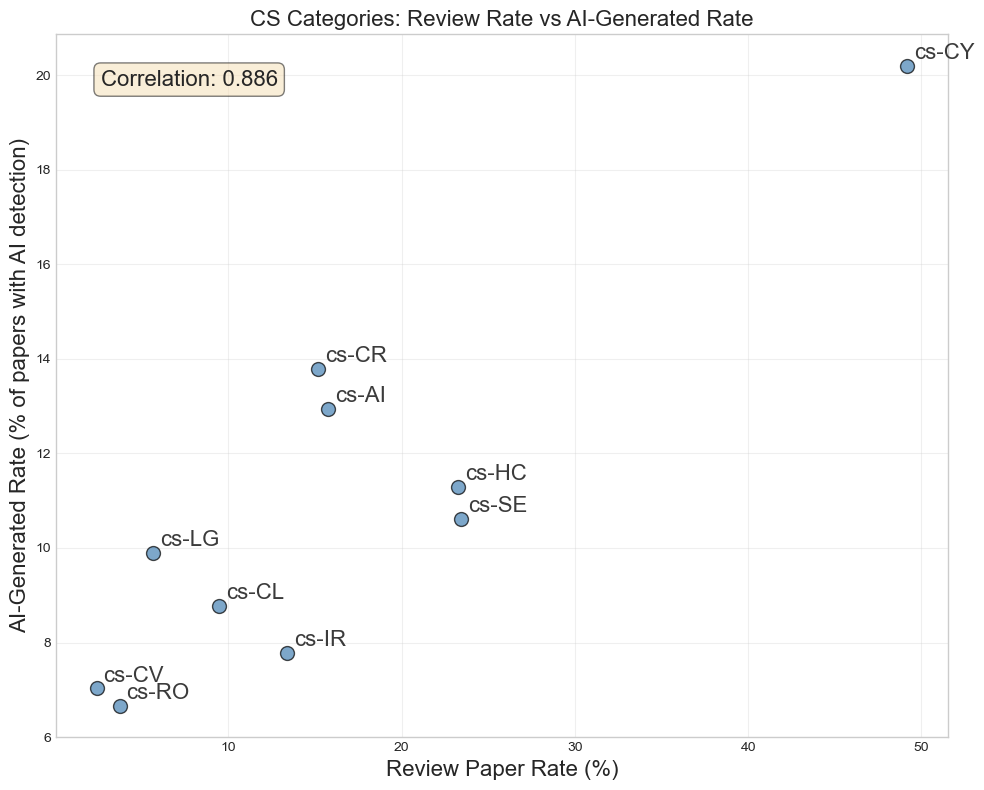


Scatter plot saved to ../figures/cs_category_review_vs_ai_scatter.png


In [732]:
# 10. CS CATEGORY SCATTER PLOT: Review Rate vs AI-Generated Rate
print("\n10. CS CATEGORY: REVIEW RATE VS AI-GENERATED RATE")
print("=" * 70)

# Use Pangram detection results which contain paper_type classifications
cs_categories = ['cs-AI', 'cs-CL', 'cs-CR', 'cs-CV', 'cs-CY', 'cs-HC', 'cs-IR', 'cs-LG', 'cs-RO', 'cs-SE']

category_stats = {}

for category in cs_categories:
    # Load Pangram results - contains both paper_type and AI detection
    results_file = RESULTS_DIR / category / 'pangram_detection_results.json'
    if results_file.exists():
        with open(results_file) as f:
            results = json.load(f)
        
        total_papers = len(results)
        # Review rate from paper_type classification
        review_papers = sum(1 for p in results if p.get('paper_type') == 'review')
        review_rate = 100 * review_papers / total_papers if total_papers > 0 else 0
        
        # AI-generated rate (among papers with detection)
        ai_flagged = sum(1 for p in results 
                         if p.get('pangram_prediction', {}).get('ai_likelihood', 0) > 0.5)
        ai_rate = 100 * ai_flagged / total_papers if total_papers > 0 else 0
    else:
        total_papers = 0
        review_rate = 0
        ai_rate = 0
    
    category_stats[category] = {
        'total_papers': total_papers,
        'review_rate': review_rate,
        'ai_rate': ai_rate
    }

# Print table
print(f"\n{'Category':<10} {'Papers':>8} {'Review %':>10} {'AI %':>10}")
print("-" * 40)
for cat in cs_categories:
    s = category_stats[cat]
    print(f"{cat:<10} {s['total_papers']:>8,} {s['review_rate']:>9.1f}% {s['ai_rate']:>9.1f}%")

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

x = [category_stats[cat]['review_rate'] for cat in cs_categories]
y = [category_stats[cat]['ai_rate'] for cat in cs_categories]

ax.scatter(x, y, s=100, alpha=0.7, c='steelblue', edgecolors='black', linewidth=1)

# Add diagonal line (y=x) for perfect correlation reference
# Use data range to draw line without changing axis limits
# diag_min = min(min(x), min(y))
# diag_max = max(max(x), max(y))
# ax.plot([diag_min, diag_max], [diag_min, diag_max], 'k--', alpha=0.3, label='y=x (perfect correlation)')

# Label each point with category name
for i, cat in enumerate(cs_categories):
    ax.annotate(cat, (x[i], y[i]), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=16, alpha=0.9)

ax.set_xlabel('Review Paper Rate (%)', fontsize=16)
ax.set_ylabel('AI-Generated Rate (% of papers with AI detection)', fontsize=16)
ax.set_title('CS Categories: Review Rate vs AI-Generated Rate', fontsize=16)
ax.grid(True, alpha=0.3)

# Add correlation info
corr = np.corrcoef(x, y)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes, 
        fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../figures/cs_category_review_vs_ai_scatter.pdf', bbox_inches='tight')
plt.show()

print(f"\nScatter plot saved to ../figures/cs_category_review_vs_ai_scatter.png")

### Summary of Data Collection

The data collection pipeline assembled multiple data sources for comprehensive analysis. Key metrics:

**Source Data:**
- **138,244 papers** collected across 10 CS subcategories from arXiv
- **Review classifications**: ~10% of papers classified as review/position papers (via LLM analysis of abstracts)
- **Pangram AI detection**: ~33,400 papers analyzed (~24% of source), with AI likelihood scores

**OpenAlex Enrichment:**
- **Work-level enrichment**: ~74% coverage, providing topic classifications, keywords, and authorship data
- **Author profiles**: 244,345 profiles with h-index and publication metrics for author-level equity analysis
- **Institution profiles**: 3,063 profiles with institutional h-index (prestige proxy) and geographic data for Global South analysis

Papers not found in OpenAlex are typically very recent preprints that haven't yet been indexed, or papers with non-standard identifiers.

## 1. Load All Data Sources

### Data Description
This section loads three primary data sources:

**1. OpenAlex Works Data** (`openalex/works_enriched.json`):
- 102,447 arXiv papers with metadata from the OpenAlex academic database
- Includes paper identifiers, publication dates, authorship information, and paper type classifications

**2. Author Profiles** (`openalex/author_profiles.jsonl`):
- 244,345 author profiles with bibliometric indicators
- Key metrics: h-index, works count, and other scholarly metrics

**3. Institution Profiles** (`openalex/institution_profiles.json`):
- 3,063 institution profiles
- Includes institutional h-index (used as prestige proxy) and geographic location

**4. AI Detection Results** (`results/{category}/pangram_detection_results.json`):
- 33,413 papers analyzed using the Pangram AI detection API
- Covers 10 CS subcategories: cs-AI, cs-CL, cs-CR, cs-CV, cs-CY, cs-HC, cs-IR, cs-LG, cs-RO, cs-SE
- Contains AI likelihood scores and paper type classifications

### Sampling Method
Papers were sampled from arXiv's CS categories during the post-LLM period (2023+). The AI detection analysis uses Pangram's API to estimate the probability that paper content was AI-generated.

In [641]:
# Load OpenAlex works data
print("Loading OpenAlex works...")
with open(OPENALEX_DIR / 'works_enriched.json') as f:
    works = json.load(f)
print(f"  Loaded {len(works):,} works")

# Load author profiles (JSONL format)
print("Loading author profiles...")
author_profiles = {}
with open(OPENALEX_DIR / 'author_profiles.jsonl') as f:
    for line in f:
        profile = json.loads(line.strip())
        author_profiles[profile['author_id']] = profile
print(f"  Loaded {len(author_profiles):,} author profiles")

# Load institution profiles
print("Loading institution profiles...")
with open(OPENALEX_DIR / 'institution_profiles.json') as f:
    institution_profiles = json.load(f)
print(f"  Loaded {len(institution_profiles):,} institution profiles")

Loading OpenAlex works...
  Loaded 102,447 works
Loading author profiles...
  Loaded 244,345 author profiles
Loading institution profiles...
  Loaded 3,063 institution profiles


In [642]:
# Load AI detection results from all CS categories
print("\nLoading AI detection results...")
ai_detection = {}

cs_categories = ['cs-AI', 'cs-CL', 'cs-CR', 'cs-CV', 'cs-CY', 'cs-HC', 'cs-IR', 'cs-LG', 'cs-RO', 'cs-SE']

for category in cs_categories:
    results_file = RESULTS_DIR / category / 'pangram_detection_results.json'
    if results_file.exists():
        with open(results_file) as f:
            results = json.load(f)
            for paper in results:
                arxiv_id = str(paper['arxiv_id'])
                ai_detection[arxiv_id] = {
                    'category': category,
                    'paper_type': paper.get('paper_type', 'unknown'),
                    'period': paper.get('period', ''),
                    'year': paper.get('year'),
                    'ai_likelihood': paper.get('pangram_prediction', {}).get('ai_likelihood', 0),
                    'ai_prediction': paper.get('pangram_prediction', {}).get('prediction', ''),
                }
        print(f"  {category}: {len(results):,} papers")

print(f"\nTotal AI detection records: {len(ai_detection):,}")


Loading AI detection results...
  cs-AI: 3,498 papers
  cs-CL: 3,600 papers
  cs-CR: 3,548 papers
  cs-CV: 3,600 papers
  cs-CY: 2,308 papers
  cs-HC: 3,437 papers
  cs-IR: 2,700 papers
  cs-LG: 3,600 papers
  cs-RO: 3,600 papers
  cs-SE: 3,522 papers

Total AI detection records: 33,413


## 2. Build Comprehensive Analysis DataFrame

### Analysis Unit
The primary unit of analysis is the **author-paper pair** (468,793 instances). This allows us to analyze how individual authors with different characteristics contribute to papers of different types.

### Dataset Composition
- **101,736 unique papers** from arXiv
- **244,345 unique authors** linked via OpenAlex

### Feature Engineering
The following derived features are created:

**Author Seniority Categories** (based on h-index):
- Junior: h-index ≤ 5
- Mid-career: h-index 6-15
- Senior: h-index 16-30
- Very Senior: h-index > 30

**Institution Prestige Categories** (based on institutional h-index):
- Low prestige: h-index ≤ 100
- Medium: h-index 101-300
- High: h-index 301-500
- Elite: h-index > 500

**Geographic Classification**:
- Global South status determined by institution's country classification

**Paper Classifications**:
- `is_review`: Binary flag for review/position papers
- `ai_flagged`: Papers with AI likelihood > 50%

In [643]:
# Build author-paper level dataframe with all features
author_paper_records = []

for arxiv_id, work in works.items():
    # Get AI detection info if available
    ai_info = ai_detection.get(arxiv_id, {})
    
    # Use paper_type from AI detection if available, otherwise from works
    paper_type = ai_info.get('paper_type') or work.get('paper_type', 'unknown')
    
    for authorship in work.get('authorships', []):
        author_id = authorship.get('author_id', '')
        if not author_id:
            continue
            
        # Get author profile
        profile = author_profiles.get(author_id, {})
        
        # Get institution info (first institution)
        inst_ids = authorship.get('institution_ids', [])
        inst_id = inst_ids[0] if inst_ids else None
        inst_profile = institution_profiles.get(inst_id, {}) if inst_id else {}
        
        author_paper_records.append({
            'arxiv_id': arxiv_id,
            'paper_type': paper_type,
            'category': ai_info.get('category', work.get('category', '')),
            'period': ai_info.get('period', ''),
            'year': ai_info.get('year') or work.get('publication_year'),
            # AI detection
            'ai_likelihood': ai_info.get('ai_likelihood', 0),
            'ai_prediction': ai_info.get('ai_prediction', ''),
            'has_ai_detection': bool(ai_info),
            # Author info
            'author_id': author_id,
            'author_position': authorship.get('position', ''),
            'is_first_author': authorship.get('position') == 'first',
            'is_last_author': authorship.get('position') == 'last',
            # Author metrics
            'author_h_index': profile.get('h_index', 0) or 0,
            'author_works_count': profile.get('works_count', 0) or 0,
            'author_cited_by_count': profile.get('cited_by_count', 0) or 0,
            'author_i10_index': profile.get('i10_index', 0) or 0,
            # Institution metrics
            'institution_id': inst_id,
            'institution_name': inst_profile.get('display_name', ''),
            'institution_h_index': inst_profile.get('h_index', 0) or 0,
            'institution_works_count': inst_profile.get('works_count', 0) or 0,
            'institution_country': inst_profile.get('country_code', ''),
            'institution_type': inst_profile.get('type', ''),
            'is_global_south': inst_profile.get('is_global_south', False),
        })

df = pd.DataFrame(author_paper_records)
print(f"Full DataFrame: {len(df):,} author-paper instances")
print(f"Unique papers: {df['arxiv_id'].nunique():,}")
print(f"Unique authors: {df['author_id'].nunique():,}")

Full DataFrame: 468,793 author-paper instances
Unique papers: 101,736
Unique authors: 244,345


In [644]:
# Create derived features

# Seniority categories based on h-index
df['seniority'] = pd.cut(
    df['author_h_index'], 
    bins=[-1, 5, 15, 30, float('inf')],
    labels=['Junior (h≤5)', 'Mid-career (h 6-15)', 'Senior (h 16-30)', 'Very Senior (h>30)']
)

# Institution prestige categories
df['inst_prestige'] = pd.cut(
    df['institution_h_index'],
    bins=[-1, 100, 300, 500, float('inf')],
    labels=['Low prestige (h≤100)', 'Medium (h 101-300)', 'High (h 301-500)', 'Elite (h>500)']
)

# AI detection flag (high likelihood = >0.5)
df['ai_flagged'] = df['ai_likelihood'] > 0.5

# Review paper flag
df['is_review'] = df['paper_type'] == 'review'

print("Feature distributions:")
print(f"\nSeniority:")
print(df['seniority'].value_counts())
print(f"\nInstitution Prestige:")
print(df['inst_prestige'].value_counts())
print(f"\nGlobal South: {df['is_global_south'].sum():,} ({100*df['is_global_south'].mean():.1f}%)")

Feature distributions:

Seniority:
seniority
Junior (h≤5)           139923
Mid-career (h 6-15)    131404
Senior (h 16-30)       102732
Very Senior (h>30)      94734
Name: count, dtype: int64

Institution Prestige:
inst_prestige
Low prestige (h≤100)    435554
Elite (h>500)            20984
Medium (h 101-300)        6599
High (h 301-500)          5656
Name: count, dtype: int64

Global South: 9,818 (2.1%)


In [645]:
# Summary statistics
print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"\nPaper type distribution:")
print(df.groupby('paper_type')['arxiv_id'].nunique())
print(f"\nAI detection coverage: {df['has_ai_detection'].mean()*100:.1f}%")
print(f"Papers flagged as AI (>50% likelihood): {df[df['ai_flagged']]['arxiv_id'].nunique():,}")
print(f"\nBy period:")
print(df[df['period'] != '']['period'].value_counts())

DATASET SUMMARY

Paper type distribution:
paper_type
other         14
regular    21237
review      3563
unknown    76922
Name: arxiv_id, dtype: int64

AI detection coverage: 24.3%
Papers flagged as AI (>50% likelihood): 2,477

By period:
period
post_llm    114080
Name: count, dtype: int64


## 3. Analysis: Who Writes Review Papers?

### Data and Sampling
This section uses the author-paper instances dataset filtered to papers with **known paper types** (review vs. regular). Papers classified as 'unknown' or 'other' are excluded from this analysis.

- **Total papers with known type**: 24,800 papers
- **Review papers**: 3,563 papers (14.4%)
- **Regular papers**: 21,237 papers (85.6%)

### Analysis Dimensions
Review paper authorship is analyzed across three dimensions:
1. **Author seniority**: Based on author h-index bins (Junior h≤5, Mid-career h 6-15, Senior h 16-30, Very Senior h>30)
2. **Institution prestige**: Based on institution h-index bins (Low h≤100, Medium h 101-300, High h 301-500, Elite h>500)
3. **Global South status**: Whether the author's institution is located in a Global South country

### Statistical Tests
- **Mann-Whitney U test**: Non-parametric test comparing h-index distributions between review and regular paper authors (two-sided)
- **Chi-square test**: Tests for association between Global South status and review paper authorship

### Output Files
- `../figures/review_rate_by_seniority.png`: Bar chart of review rates by seniority + h-index distribution by paper type

In [646]:
# Filter to papers with known types
df_typed = df[df['paper_type'].isin(['review', 'regular'])].copy()
print(f"Papers with known type: {df_typed['arxiv_id'].nunique():,}")
print(f"Review papers: {df_typed[df_typed['is_review']]['arxiv_id'].nunique():,}")
print(f"Regular papers: {df_typed[~df_typed['is_review']]['arxiv_id'].nunique():,}")

Papers with known type: 24,800
Review papers: 3,563
Regular papers: 21,237


In [647]:
# Review rate by seniority
print("\n" + "="*60)
print("REVIEW PAPER RATES BY AUTHOR SENIORITY")
print("="*60)

seniority_stats = df_typed.groupby('seniority').agg(
    total_instances=('arxiv_id', 'count'),
    review_instances=('is_review', 'sum'),
    review_rate=('is_review', 'mean'),
    mean_h_index=('author_h_index', 'mean'),
).round(4)
seniority_stats['review_rate_pct'] = (seniority_stats['review_rate'] * 100).round(2)
print(seniority_stats)


REVIEW PAPER RATES BY AUTHOR SENIORITY
                     total_instances  review_instances  review_rate  \
seniority                                                             
Junior (h≤5)                   40274              5380       0.1336   
Mid-career (h 6-15)            30984              4073       0.1315   
Senior (h 16-30)               23069              3160       0.1370   
Very Senior (h>30)             19689              2559       0.1300   

                     mean_h_index  review_rate_pct  
seniority                                           
Junior (h≤5)               2.0242            13.36  
Mid-career (h 6-15)        9.9633            13.15  
Senior (h 16-30)          22.0386            13.70  
Very Senior (h>30)        51.6657            13.00  


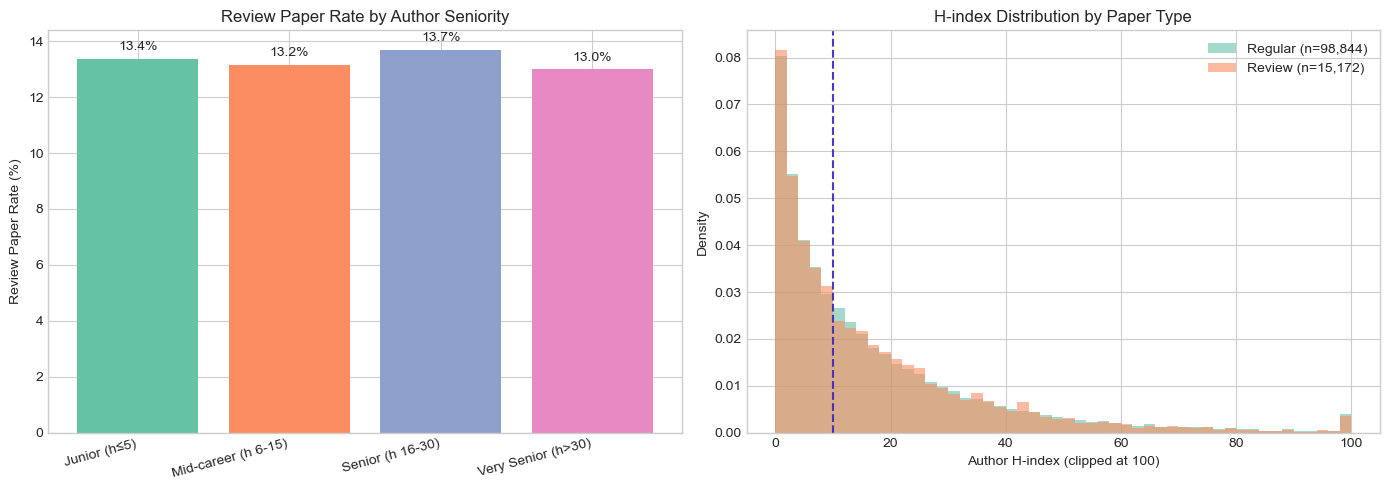

In [648]:
# Visualize review rates by seniority
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of review rates
ax1 = axes[0]
seniority_order = ['Junior (h≤5)', 'Mid-career (h 6-15)', 'Senior (h 16-30)', 'Very Senior (h>30)']
review_rates = [seniority_stats.loc[s, 'review_rate_pct'] for s in seniority_order if s in seniority_stats.index]
colors = sns.color_palette('Set2', len(seniority_order))
bars = ax1.bar(range(len(review_rates)), review_rates, color=colors)
ax1.set_xticks(range(len(review_rates)))
ax1.set_xticklabels([s for s in seniority_order if s in seniority_stats.index], rotation=15, ha='right')
ax1.set_ylabel('Review Paper Rate (%)')
ax1.set_title('Review Paper Rate by Author Seniority')
for i, (bar, rate) in enumerate(zip(bars, review_rates)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{rate:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# H-index distribution by paper type
ax2 = axes[1]
review_h = df_typed[df_typed['is_review']]['author_h_index'].clip(upper=100)
regular_h = df_typed[~df_typed['is_review']]['author_h_index'].clip(upper=100)
ax2.hist(regular_h, bins=50, alpha=0.6, label=f'Regular (n={len(regular_h):,})', density=True)
ax2.hist(review_h, bins=50, alpha=0.6, label=f'Review (n={len(review_h):,})', density=True)
ax2.set_xlabel('Author H-index (clipped at 100)')
ax2.set_ylabel('Density')
ax2.set_title('H-index Distribution by Paper Type')
ax2.legend()
ax2.axvline(review_h.median(), color='orange', linestyle='--', alpha=0.7, label=f'Review median: {review_h.median():.1f}')
ax2.axvline(regular_h.median(), color='blue', linestyle='--', alpha=0.7, label=f'Regular median: {regular_h.median():.1f}')

plt.tight_layout()
plt.savefig('../figures/review_rate_by_seniority.png', dpi=150, bbox_inches='tight')
plt.show()

In [649]:
# Statistical test: H-index comparison
review_h_index = df_typed[df_typed['is_review']]['author_h_index']
regular_h_index = df_typed[~df_typed['is_review']]['author_h_index']

# Mann-Whitney U test (non-parametric)
stat, p_value = stats.mannwhitneyu(review_h_index, regular_h_index, alternative='two-sided')

print("\n" + "="*60)
print("STATISTICAL TEST: H-INDEX BY PAPER TYPE")
print("="*60)
print(f"Review paper authors - Median h-index: {review_h_index.median():.1f}, Mean: {review_h_index.mean():.2f}")
print(f"Regular paper authors - Median h-index: {regular_h_index.median():.1f}, Mean: {regular_h_index.mean():.2f}")
print(f"\nMann-Whitney U test: U={stat:,.0f}, p={p_value:.2e}")
if p_value < 0.05:
    print("→ Statistically significant difference (p < 0.05)")


STATISTICAL TEST: H-INDEX BY PAPER TYPE
Review paper authors - Median h-index: 10.0, Mean: 16.55
Regular paper authors - Median h-index: 10.0, Mean: 16.84

Mann-Whitney U test: U=748,011,018, p=6.29e-01


In [650]:
# Review rate by institution prestige
print("\n" + "="*60)
print("REVIEW PAPER RATES BY INSTITUTION PRESTIGE")
print("="*60)

# Filter to rows with institution data
df_with_inst = df_typed[df_typed['institution_h_index'] > 0].copy()
print(f"Author-paper instances with institution data: {len(df_with_inst):,}")

prestige_stats = df_with_inst.groupby('inst_prestige').agg(
    total_instances=('arxiv_id', 'count'),
    review_instances=('is_review', 'sum'),
    review_rate=('is_review', 'mean'),
    mean_inst_h_index=('institution_h_index', 'mean'),
).round(4)
prestige_stats['review_rate_pct'] = (prestige_stats['review_rate'] * 100).round(2)
print(prestige_stats)


REVIEW PAPER RATES BY INSTITUTION PRESTIGE
Author-paper instances with institution data: 2,371
                      total_instances  review_instances  review_rate  \
inst_prestige                                                          
Low prestige (h≤100)              295                44       0.1492   
Medium (h 101-300)                549                99       0.1803   
High (h 301-500)                  343                53       0.1545   
Elite (h>500)                    1184               259       0.2188   

                      mean_inst_h_index  review_rate_pct  
inst_prestige                                             
Low prestige (h≤100)            56.9966            14.92  
Medium (h 101-300)             196.1767            18.03  
High (h 301-500)               408.2974            15.45  
Elite (h>500)                 1025.7365            21.88  


In [651]:
# Review rate by Global South status
print("\n" + "="*60)
print("REVIEW PAPER RATES BY GLOBAL SOUTH STATUS")
print("="*60)

# Filter to rows with country data
df_with_country = df_typed[df_typed['institution_country'] != ''].copy()
print(f"Author-paper instances with country data: {len(df_with_country):,}")

gs_stats = df_with_country.groupby('is_global_south').agg(
    total_instances=('arxiv_id', 'count'),
    review_instances=('is_review', 'sum'),
    review_rate=('is_review', 'mean'),
).round(4)
gs_stats.index = ['Global North', 'Global South']
gs_stats['review_rate_pct'] = (gs_stats['review_rate'] * 100).round(2)
print(gs_stats)

# Chi-square test
contingency = pd.crosstab(df_with_country['is_global_south'], df_with_country['is_review'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-square test: χ²={chi2:.2f}, p={p_value:.2e}")


REVIEW PAPER RATES BY GLOBAL SOUTH STATUS
Author-paper instances with country data: 2,371
              total_instances  review_instances  review_rate  review_rate_pct
Global North             2056               427       0.2077            20.77
Global South              315                28       0.0889             8.89

Chi-square test: χ²=24.10, p=9.16e-07


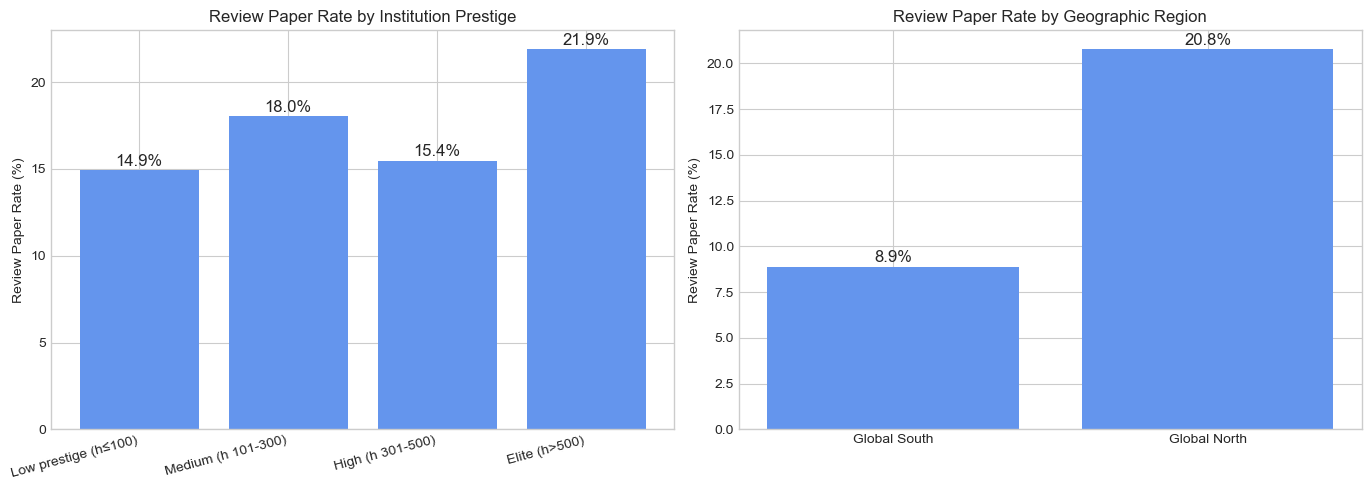

In [652]:
# Visualize review rates by institution prestige and Global South
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Institution prestige
ax1 = axes[0]
prestige_order = ['Low prestige (h≤100)', 'Medium (h 101-300)', 'High (h 301-500)', 'Elite (h>500)']
rates = [prestige_stats.loc[p, 'review_rate_pct'] for p in prestige_order if p in prestige_stats.index]
labels = [p for p in prestige_order if p in prestige_stats.index]
bars = ax1.bar(range(len(rates)), rates, color='cornflowerblue')
ax1.set_xticks(range(len(rates)))
ax1.set_xticklabels(labels, rotation=15, ha='right')
ax1.set_ylabel('Review Paper Rate (%)')
ax1.set_title('Review Paper Rate by Institution Prestige')
for bar, rate in zip(bars, rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{rate:.1f}%', 
             ha='center', va='bottom', fontsize=12)

# Global South
ax2 = axes[1]
gs_rates = [gs_stats.loc['Global South', 'review_rate_pct'], gs_stats.loc['Global North', 'review_rate_pct']]
bars = ax2.bar(['Global South', 'Global North'], gs_rates, color='cornflowerblue')
ax2.set_ylabel('Review Paper Rate (%)')
ax2.set_title('Review Paper Rate by Geographic Region')
for bar, rate in zip(bars, gs_rates):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{rate:.1f}%', 
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig('../figures/review_rate_by_prestige_region.pdf', bbox_inches='tight')
plt.show()

### Paper-Level Analysis (Controlling for Multi-Author Counting)

The author-instance level analysis above may over-represent papers with many authors from similar institutions. 
Below we provide an alternative paper-level analysis where each paper is counted once, 
using the first author's institution to assign prestige/region.

In [653]:
# Create paper-level dataset using first author's institution
# First, identify first author for each paper (is_first_author == True)
df_first_authors = df_typed[df_typed['is_first_author'] == True].copy()

# Filter to papers where first author has institution data
df_papers_with_inst = df_first_authors[df_first_authors['institution_h_index'] > 0].copy()
df_papers_with_country = df_first_authors[df_first_authors['institution_country'] != ''].copy()

print(f"Total papers in df_typed: {df_typed['arxiv_id'].nunique():,}")
print(f"Papers with first author institution data: {len(df_papers_with_inst):,}")
print(f"Papers with first author country data: {len(df_papers_with_country):,}")

Total papers in df_typed: 24,800
Papers with first author institution data: 603
Papers with first author country data: 603


In [654]:
# Paper-level review rate by institution prestige (first author)
print("\n" + "="*60)
print("PAPER-LEVEL: REVIEW RATES BY INSTITUTION PRESTIGE (First Author)")
print("="*60)

paper_prestige_stats = df_papers_with_inst.groupby('inst_prestige').agg(
    total_papers=('arxiv_id', 'count'),
    review_papers=('is_review', 'sum'),
    review_rate=('is_review', 'mean'),
).round(4)
paper_prestige_stats['review_rate_pct'] = (paper_prestige_stats['review_rate'] * 100).round(2)
print(paper_prestige_stats)

# Chi-square test
contingency = pd.crosstab(df_papers_with_inst['inst_prestige'], df_papers_with_inst['is_review'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-square test: χ²={chi2:.2f}, p={p_value:.2e}")


PAPER-LEVEL: REVIEW RATES BY INSTITUTION PRESTIGE (First Author)
                      total_papers  review_papers  review_rate  \
inst_prestige                                                    
Low prestige (h≤100)            81             15       0.1852   
Medium (h 101-300)             152             35       0.2303   
High (h 301-500)                72             13       0.1806   
Elite (h>500)                  298             69       0.2315   

                      review_rate_pct  
inst_prestige                          
Low prestige (h≤100)            18.52  
Medium (h 101-300)              23.03  
High (h 301-500)                18.06  
Elite (h>500)                   23.15  

Chi-square test: χ²=1.55, p=6.71e-01


In [655]:
# Paper-level review rate by Global South status (first author)
print("\n" + "="*60)
print("PAPER-LEVEL: REVIEW RATES BY GLOBAL SOUTH STATUS (First Author)")
print("="*60)

paper_gs_stats = df_papers_with_country.groupby('is_global_south').agg(
    total_papers=('arxiv_id', 'count'),
    review_papers=('is_review', 'sum'),
    review_rate=('is_review', 'mean'),
).round(4)
paper_gs_stats.index = ['Global North', 'Global South']
paper_gs_stats['review_rate_pct'] = (paper_gs_stats['review_rate'] * 100).round(2)
print(paper_gs_stats)

# Chi-square test
contingency = pd.crosstab(df_papers_with_country['is_global_south'], df_papers_with_country['is_review'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-square test: χ²={chi2:.2f}, p={p_value:.2e}")


PAPER-LEVEL: REVIEW RATES BY GLOBAL SOUTH STATUS (First Author)
              total_papers  review_papers  review_rate  review_rate_pct
Global North           528            122       0.2311            23.11
Global South            75             10       0.1333            13.33

Chi-square test: χ²=3.12, p=7.74e-02


In [656]:
# Compare author-instance vs paper-level results
print("\n" + "="*60)
print("COMPARISON: Author-Instance vs Paper-Level Analysis")
print("="*60)

print("\n--- Institution Prestige ---")
comparison_prestige = pd.DataFrame({
    'Author-Instance (%)': prestige_stats['review_rate_pct'],
    'Paper-Level (%)': paper_prestige_stats['review_rate_pct'],
})
print(comparison_prestige)

print("\n--- Global South Status ---")
comparison_gs = pd.DataFrame({
    'Author-Instance (%)': gs_stats['review_rate_pct'],
    'Paper-Level (%)': paper_gs_stats['review_rate_pct'],
})
print(comparison_gs)


COMPARISON: Author-Instance vs Paper-Level Analysis

--- Institution Prestige ---
                      Author-Instance (%)  Paper-Level (%)
inst_prestige                                             
Low prestige (h≤100)                14.92            18.52
Medium (h 101-300)                  18.03            23.03
High (h 301-500)                    15.45            18.06
Elite (h>500)                       21.88            23.15

--- Global South Status ---
              Author-Instance (%)  Paper-Level (%)
Global North                20.77            23.11
Global South                 8.89            13.33


## 4. Analysis: Who is Flagged for AI-Generated Content?

This section examines which groups are more likely to have their papers flagged by AI detection.

### Data and Sampling
- **Analysis subset**: Post-LLM period papers (2023+) with AI detection data from Pangram
- **Papers analyzed**: 24,814 unique papers with AI detection scores
- **Papers flagged**: 2,477 papers with >50% AI likelihood (threshold for "flagged")
- **Unit of analysis**: Author-paper instances (114,080 total records with AI detection)
- **Note**: Institution-level analyses are limited to 2,371 instances with valid institution data

### Analysis Dimensions
1. **Author Seniority**: AI flag rates and mean AI likelihood by h-index quartiles
2. **Institution Prestige**: AI detection patterns by institutional h-index tiers
3. **Geographic Region**: Global South vs Global North comparison

### Statistical Tests
- **Chi-square test**: Tests for association between Global South status and AI flagging
- **Descriptive statistics**: Mean AI likelihood scores and flag rates by group

### Output Files
- `../figures/ai_detection_by_seniority.png`: Box plots and bar charts of AI detection by author seniority
- `../figures/ai_detection_by_prestige_region.png`: AI detection patterns by institution prestige and geographic region

In [657]:
# Filter to papers with AI detection data (post-LLM period)
df_ai = df[df['has_ai_detection'] & (df['period'] == 'post_llm')].copy()
print(f"Papers with AI detection (post-LLM): {df_ai['arxiv_id'].nunique():,}")
print(f"AI flagged (>50% likelihood): {df_ai[df_ai['ai_flagged']]['arxiv_id'].nunique():,}")
print(f"\nAI likelihood distribution:")
print(df_ai['ai_likelihood'].describe())

Papers with AI detection (post-LLM): 24,814
AI flagged (>50% likelihood): 2,477

AI likelihood distribution:
count    114080.000000
mean          0.093454
std           0.272769
min           0.000000
25%           0.000002
50%           0.000010
75%           0.000146
max           1.000000
Name: ai_likelihood, dtype: float64


In [658]:
# AI flag rate by seniority
print("\n" + "="*60)
print("AI FLAG RATES BY AUTHOR SENIORITY")
print("="*60)

ai_seniority_stats = df_ai.groupby('seniority').agg(
    total_instances=('arxiv_id', 'count'),
    flagged_instances=('ai_flagged', 'sum'),
    flag_rate=('ai_flagged', 'mean'),
    mean_ai_likelihood=('ai_likelihood', 'mean'),
).round(4)
ai_seniority_stats['flag_rate_pct'] = (ai_seniority_stats['flag_rate'] * 100).round(2)
print(ai_seniority_stats)


AI FLAG RATES BY AUTHOR SENIORITY
                     total_instances  flagged_instances  flag_rate  \
seniority                                                            
Junior (h≤5)                   40294               4417     0.1096   
Mid-career (h 6-15)            31002               2387     0.0770   
Senior (h 16-30)               23082               1736     0.0752   
Very Senior (h>30)             19702               1323     0.0672   

                     mean_ai_likelihood  flag_rate_pct  
seniority                                               
Junior (h≤5)                     0.1178          10.96  
Mid-career (h 6-15)              0.0833           7.70  
Senior (h 16-30)                 0.0816           7.52  
Very Senior (h>30)               0.0735           6.72  


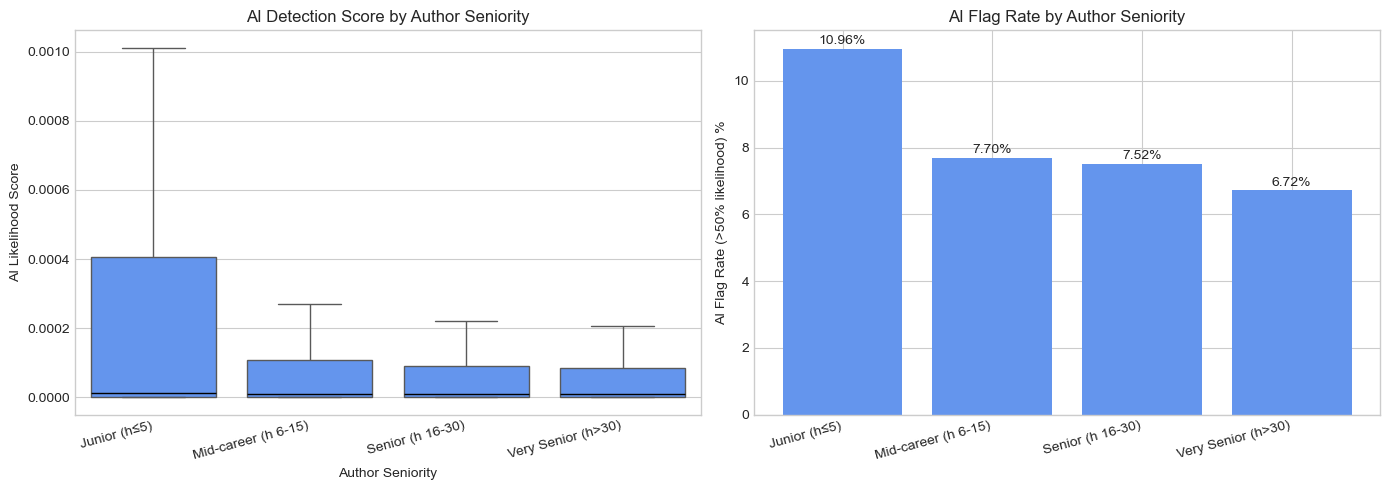

In [719]:
# AI likelihood distribution by seniority
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of AI likelihood by seniority
ax1 = axes[0]
seniority_order = ['Junior (h≤5)', 'Mid-career (h 6-15)', 'Senior (h 16-30)', 'Very Senior (h>30)']
df_ai_valid = df_ai[df_ai['seniority'].notna()]
# sns.boxplot(data=df_ai_valid, x='seniority', y='ai_likelihood', order=seniority_order, ax=ax1, color='cornflowerblue', showfliers=False)
# sns.boxplot(data=df_ai_valid, x='seniority', y='ai_likelihood', order=seniority_order, ax=ax1, 
#             palette=['cornflowerblue']*len(seniority_order), showfliers=False)
sns.boxplot(data=df_ai_valid, x='seniority', y='ai_likelihood', order=seniority_order, ax=ax1,
            showfliers=False,
            boxprops=dict(facecolor='cornflowerblue'),
            medianprops=dict(color='black'))
ax1.set_xlabel('Author Seniority')
ax1.set_ylabel('AI Likelihood Score')
ax1.set_title('AI Detection Score by Author Seniority')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')

# AI flag rate bar chart
ax2 = axes[1]
rates = [ai_seniority_stats.loc[s, 'flag_rate_pct'] for s in seniority_order if s in ai_seniority_stats.index]
labels = [s for s in seniority_order if s in ai_seniority_stats.index]
bars = ax2.bar(range(len(rates)), rates, color='cornflowerblue')
ax2.set_xticks(range(len(rates)))
ax2.set_xticklabels(labels, rotation=15, ha='right')
ax2.set_ylabel('AI Flag Rate (>50% likelihood) %')
ax2.set_title('AI Flag Rate by Author Seniority')
for bar, rate in zip(bars, rates):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{rate:.2f}%', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/ai_detection_by_seniority.pdf', bbox_inches='tight')
plt.show()

In [660]:
# AI flag rate by institution prestige
print("\n" + "="*60)
print("AI FLAG RATES BY INSTITUTION PRESTIGE")
print("="*60)

df_ai_inst = df_ai[df_ai['institution_h_index'] > 0].copy()
print(f"Author-paper instances with institution data: {len(df_ai_inst):,}")

ai_prestige_stats = df_ai_inst.groupby('inst_prestige').agg(
    total_instances=('arxiv_id', 'count'),
    flagged_instances=('ai_flagged', 'sum'),
    flag_rate=('ai_flagged', 'mean'),
    mean_ai_likelihood=('ai_likelihood', 'mean'),
).round(4)
ai_prestige_stats['flag_rate_pct'] = (ai_prestige_stats['flag_rate'] * 100).round(2)
print(ai_prestige_stats)


AI FLAG RATES BY INSTITUTION PRESTIGE
Author-paper instances with institution data: 2,371
                      total_instances  flagged_instances  flag_rate  \
inst_prestige                                                         
Low prestige (h≤100)              295                  3     0.0102   
Medium (h 101-300)                549                 21     0.0383   
High (h 301-500)                  343                  8     0.0233   
Elite (h>500)                    1184                 27     0.0228   

                      mean_ai_likelihood  flag_rate_pct  
inst_prestige                                            
Low prestige (h≤100)              0.0180           1.02  
Medium (h 101-300)                0.0416           3.83  
High (h 301-500)                  0.0249           2.33  
Elite (h>500)                     0.0291           2.28  


In [661]:
# AI flag rate by Global South status
print("\n" + "="*60)
print("AI FLAG RATES BY GLOBAL SOUTH STATUS")
print("="*60)

df_ai_country = df_ai[df_ai['institution_country'] != ''].copy()
print(f"Author-paper instances with country data: {len(df_ai_country):,}")

ai_gs_stats = df_ai_country.groupby('is_global_south').agg(
    total_instances=('arxiv_id', 'count'),
    flagged_instances=('ai_flagged', 'sum'),
    flag_rate=('ai_flagged', 'mean'),
    mean_ai_likelihood=('ai_likelihood', 'mean'),
).round(4)
ai_gs_stats.index = ['Global North', 'Global South']
ai_gs_stats['flag_rate_pct'] = (ai_gs_stats['flag_rate'] * 100).round(2)
print(ai_gs_stats)

# Chi-square test for AI flagging by Global South
contingency = pd.crosstab(df_ai_country['is_global_south'], df_ai_country['ai_flagged'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-square test: χ²={chi2:.2f}, p={p_value:.2e}")


AI FLAG RATES BY GLOBAL SOUTH STATUS
Author-paper instances with country data: 2,371
              total_instances  flagged_instances  flag_rate  \
Global North             2056                 53     0.0258   
Global South              315                  6     0.0190   

              mean_ai_likelihood  flag_rate_pct  
Global North              0.0307           2.58  
Global South              0.0257           1.90  

Chi-square test: χ²=0.27, p=6.03e-01


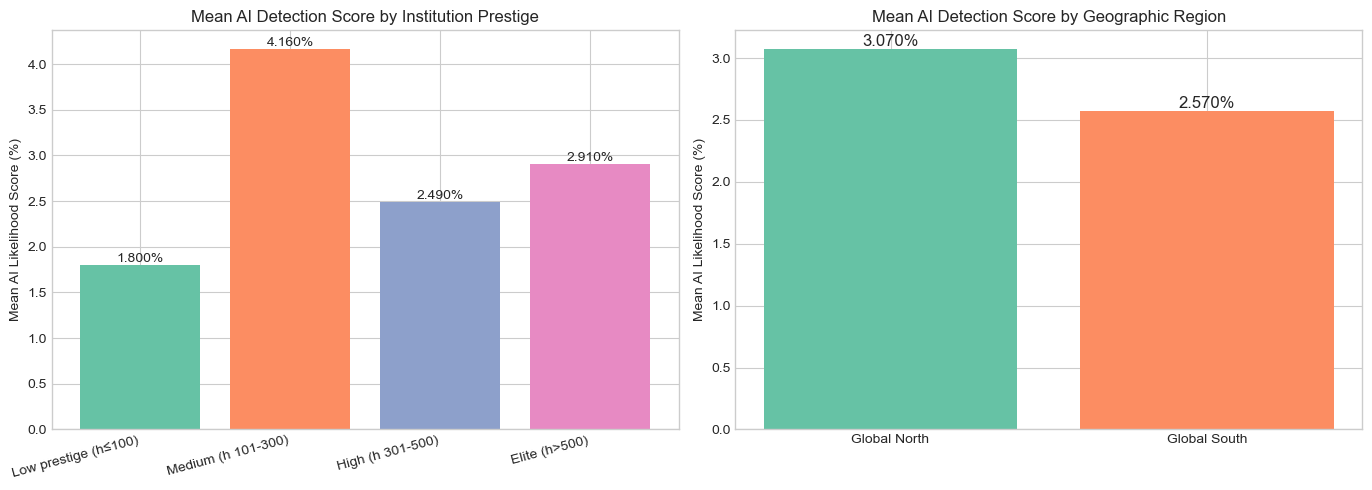

In [662]:
# Visualize AI detection by prestige and Global South
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Institution prestige
ax1 = axes[0]
prestige_order = ['Low prestige (h≤100)', 'Medium (h 101-300)', 'High (h 301-500)', 'Elite (h>500)']
rates = [ai_prestige_stats.loc[p, 'mean_ai_likelihood']*100 for p in prestige_order if p in ai_prestige_stats.index]
labels = [p for p in prestige_order if p in ai_prestige_stats.index]
bars = ax1.bar(range(len(rates)), rates, color=sns.color_palette('Set2', len(rates)))
ax1.set_xticks(range(len(rates)))
ax1.set_xticklabels(labels, rotation=15, ha='right')
ax1.set_ylabel('Mean AI Likelihood Score (%)')
ax1.set_title('Mean AI Detection Score by Institution Prestige')
for bar, rate in zip(bars, rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{rate:.3f}%', 
             ha='center', va='bottom', fontsize=10)

# Global South
ax2 = axes[1]
gs_rates = [ai_gs_stats.loc['Global North', 'mean_ai_likelihood']*100, 
            ai_gs_stats.loc['Global South', 'mean_ai_likelihood']*100]
bars = ax2.bar(['Global North', 'Global South'], gs_rates, color=['#66c2a5', '#fc8d62'])
ax2.set_ylabel('Mean AI Likelihood Score (%)')
ax2.set_title('Mean AI Detection Score by Geographic Region')
for bar, rate in zip(bars, gs_rates):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{rate:.3f}%', 
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig('../figures/ai_detection_by_prestige_region.pdf', bbox_inches='tight')
plt.show()

## 5. Intersectional Analysis

### Data and Sampling
This section analyzes the intersection of multiple disadvantaged categories and how they compound effects on review paper authorship. The analysis is limited to **author-paper instances with known institution country data** (2,371 instances out of 114,080 total), since Global South classification requires country information.

### Analysis Dimensions
Three binary disadvantage indicators are defined:
1. **is_junior**: Author h-index ≤ 5 (junior researchers)
2. **is_low_prestige**: Institution h-index ≤ 100 (low prestige institutions)
3. **is_global_south**: Author's institution is in a Global South country

Each author-paper instance is assigned a **disadvantage_count** (0-3) based on the number of these categories that apply.

### Analysis Methodology
- **Disadvantage count analysis**: Review paper rates are calculated for each disadvantage level (0=most advantaged to 3=most disadvantaged)
- **Detailed intersectional breakdown**: All 8 possible combinations of the three binary dimensions are examined (e.g., 'Junior + Low Prestige + Global South')
- Review rates are calculated as the proportion of instances associated with review papers

### Output Files
- `../figures/intersectional_analysis.png`: Two-panel figure showing (1) review rates by disadvantage count and (2) highest/lowest review rates by intersectional group

In [663]:
# Define disadvantaged categories
df_intersect = df_typed[df_typed['institution_country'] != ''].copy()

df_intersect['is_junior'] = df_intersect['author_h_index'] <= 5
df_intersect['is_low_prestige'] = df_intersect['institution_h_index'] <= 100

# Count disadvantaged categories
df_intersect['disadvantage_count'] = (
    df_intersect['is_junior'].astype(int) + 
    df_intersect['is_low_prestige'].astype(int) + 
    df_intersect['is_global_south'].astype(int)
)

print("Disadvantage count distribution:")
print(df_intersect['disadvantage_count'].value_counts().sort_index())

Disadvantage count distribution:
disadvantage_count
0    1262
1     891
2     205
3      13
Name: count, dtype: int64


In [664]:
# Review rate by disadvantage count
print("\n" + "="*60)
print("REVIEW PAPER RATES BY DISADVANTAGE COUNT")
print("="*60)

intersect_stats = df_intersect.groupby('disadvantage_count').agg(
    total_instances=('arxiv_id', 'count'),
    review_instances=('is_review', 'sum'),
    review_rate=('is_review', 'mean'),
).round(4)
intersect_stats['review_rate_pct'] = (intersect_stats['review_rate'] * 100).round(2)
intersect_stats.index = ['0 (Most advantaged)', '1 disadvantage', '2 disadvantages', '3 (Most disadvantaged)']
print(intersect_stats)


REVIEW PAPER RATES BY DISADVANTAGE COUNT
                        total_instances  review_instances  review_rate  \
0 (Most advantaged)                1262               275       0.2179   
1 disadvantage                      891               156       0.1751   
2 disadvantages                     205                22       0.1073   
3 (Most disadvantaged)               13                 2       0.1538   

                        review_rate_pct  
0 (Most advantaged)               21.79  
1 disadvantage                    17.51  
2 disadvantages                   10.73  
3 (Most disadvantaged)            15.38  


In [665]:
# Detailed intersectional breakdown
print("\n" + "="*60)
print("DETAILED INTERSECTIONAL ANALYSIS")
print("="*60)

# Create intersection groups
df_intersect['group'] = (
    df_intersect['is_junior'].map({True: 'Junior', False: 'Senior'}) + ' + ' +
    df_intersect['is_low_prestige'].map({True: 'Low Prestige', False: 'High Prestige'}) + ' + ' +
    df_intersect['is_global_south'].map({True: 'Global South', False: 'Global North'})
)

detailed_stats = df_intersect.groupby('group').agg(
    total=('arxiv_id', 'count'),
    review_rate=('is_review', 'mean'),
).round(4)
detailed_stats['review_rate_pct'] = (detailed_stats['review_rate'] * 100).round(2)
detailed_stats = detailed_stats.sort_values('review_rate', ascending=False)
print(detailed_stats.head(10))


DETAILED INTERSECTIONAL ANALYSIS
                                       total  review_rate  review_rate_pct
group                                                                     
Senior + High Prestige + Global North   1262       0.2179            21.79
Junior + High Prestige + Global North    532       0.2124            21.24
Senior + Low Prestige + Global North     154       0.1623            16.23
Junior + Low Prestige + Global South      13       0.1538            15.38
Senior + Low Prestige + Global South      20       0.1500            15.00
Junior + Low Prestige + Global North     108       0.1296            12.96
Senior + High Prestige + Global South    205       0.0878             8.78
Junior + High Prestige + Global South     77       0.0649             6.49


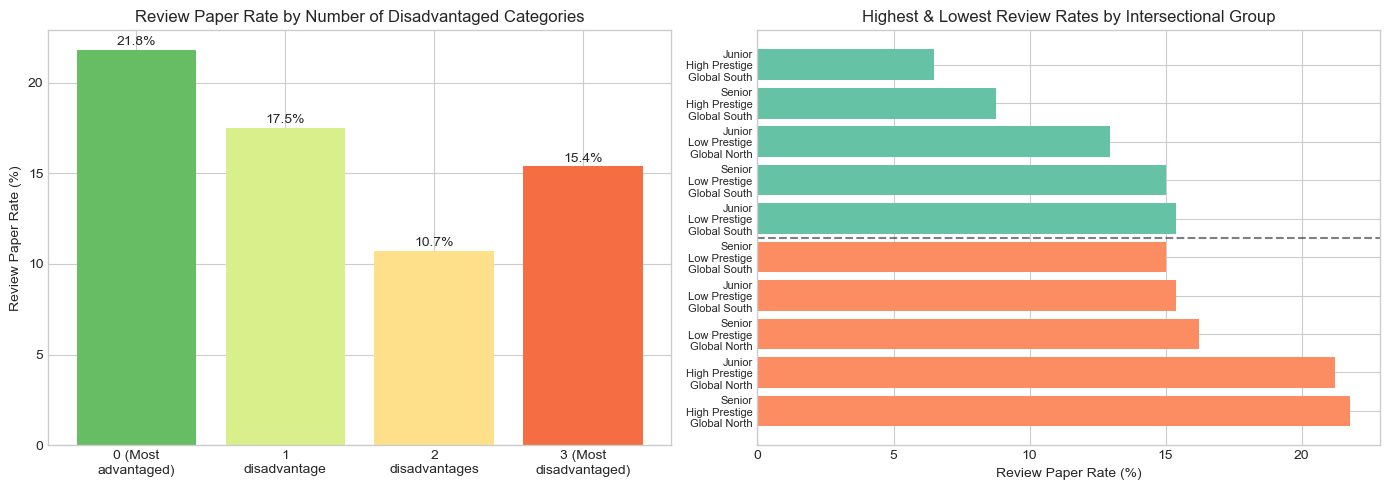

In [666]:
# Visualize intersectional effects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Review rate by disadvantage count
ax1 = axes[0]
x_labels = ['0 (Most\nadvantaged)', '1\ndisadvantage', '2\ndisadvantages', '3 (Most\ndisadvantaged)']
rates = intersect_stats['review_rate_pct'].values
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(rates)))
bars = ax1.bar(range(len(rates)), rates, color=colors)
ax1.set_xticks(range(len(rates)))
ax1.set_xticklabels(x_labels)
ax1.set_ylabel('Review Paper Rate (%)')
ax1.set_title('Review Paper Rate by Number of Disadvantaged Categories')
for bar, rate in zip(bars, rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{rate:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Top/bottom groups comparison
ax2 = axes[1]
top_5 = detailed_stats.head(5)
bottom_5 = detailed_stats.tail(5)
comparison = pd.concat([top_5, bottom_5])
y_pos = range(len(comparison))
colors = ['#fc8d62' if i < 5 else '#66c2a5' for i in range(len(comparison))]
bars = ax2.barh(y_pos, comparison['review_rate_pct'], color=colors)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([g.replace(' + ', '\n') for g in comparison.index], fontsize=8)
ax2.set_xlabel('Review Paper Rate (%)')
ax2.set_title('Highest & Lowest Review Rates by Intersectional Group')
ax2.axhline(4.5, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../figures/intersectional_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Pre-LLM vs Post-LLM Temporal Analysis

Examine how review paper patterns and equity effects differ between pre-LLM (before 2023) and post-LLM periods.

### Data and Sampling
This section uses `df_typed` (the filtered dataset with known paper types: 'review' or 'regular') with an added temporal dimension. Papers are classified into:
- **Pre-LLM period**: 2020-2022 (before widespread LLM availability)
- **Post-LLM period**: 2023+ (after ChatGPT release in November 2022)

Note: The current dataset appears to contain only post-LLM period data (24,800 papers with 114,016 author-paper instances).

### Analysis Dimensions
Review paper rates are examined across multiple author/institution characteristics within each time period:
- **Overall review rates by period**: Comparing baseline review paper proportions
- **By seniority level**: Junior (h≤5), Mid-career (h 6-15), Senior (h 16-30), Very Senior (h>30)
- **By Global South status**: Comparing Global North vs Global South institution affiliations
- **By institution prestige**: Low (h≤100), Medium (h 101-300), High (h 301-500), Elite (h>500)

### Statistical Tests
- **Chi-square test**: Tests whether review paper rates differ significantly between pre-LLM and post-LLM periods (conditional on both periods being present in data)
- **Pivot tables**: Used to compare rates across subgroups between periods, with 'Change' column showing period-over-period differences

### Output Files
- `../figures/temporal_review_rates.png`: Visualization of review rate trends over time (if generated)

In [667]:
# Create period column based on year if not already set
# Pre-LLM: 2020-2022, Post-LLM: 2023+
print("=" * 60)
print("PRE-LLM VS POST-LLM TEMPORAL ANALYSIS")
print("=" * 60)

# Use existing period if available, otherwise derive from year
df_temporal = df_typed.copy()
df_temporal['period_derived'] = df_temporal.apply(
    lambda x: x['period'] if x['period'] else ('pre_llm' if x['year'] and x['year'] < 2023 else 'post_llm'),
    axis=1
)

# Filter to rows with valid periods
df_temporal = df_temporal[df_temporal['period_derived'].isin(['pre_llm', 'post_llm'])]

print(f"\nPapers by period:")
print(df_temporal.groupby('period_derived')['arxiv_id'].nunique())
print(f"\nAuthor-paper instances by period:")
print(df_temporal['period_derived'].value_counts())

PRE-LLM VS POST-LLM TEMPORAL ANALYSIS

Papers by period:
period_derived
post_llm    24800
Name: arxiv_id, dtype: int64

Author-paper instances by period:
period_derived
post_llm    114016
Name: count, dtype: int64


In [668]:
# Overall review rates by period
print("\n" + "="*60)
print("REVIEW PAPER RATES BY PERIOD")
print("="*60)

period_stats = df_temporal.groupby('period_derived').agg(
    unique_papers=('arxiv_id', 'nunique'),
    review_papers=('is_review', lambda x: df_temporal.loc[x.index].groupby('arxiv_id')['is_review'].first().sum()),
    total_instances=('arxiv_id', 'count'),
    review_rate=('is_review', 'mean'),
).round(4)
period_stats['review_rate_pct'] = (period_stats['review_rate'] * 100).round(2)

# Rename index labels
period_stats.index = period_stats.index.map({'pre_llm': 'Pre-LLM (2020-2022)', 'post_llm': 'Post-LLM (2023+)'})
print(period_stats)

# Chi-square test (only if both periods present)
if len(period_stats) >= 2:
    contingency = pd.crosstab(df_temporal['period_derived'], df_temporal['is_review'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    print(f"\nChi-square test: χ²={chi2:.2f}, p={p_value:.2e}")
else:
    print("\nNote: Only one period present in data, skipping chi-square test")


REVIEW PAPER RATES BY PERIOD
                  unique_papers  review_papers  total_instances  review_rate  \
period_derived                                                                 
Post-LLM (2023+)          24800           3563           114016       0.1331   

                  review_rate_pct  
period_derived                     
Post-LLM (2023+)            13.31  

Note: Only one period present in data, skipping chi-square test


In [669]:
# Review rates by seniority AND period
print("\n" + "="*60)
print("REVIEW RATES BY SENIORITY AND PERIOD")
print("="*60)

seniority_period_stats = df_temporal.groupby(['seniority', 'period_derived']).agg(
    total_instances=('arxiv_id', 'count'),
    review_rate=('is_review', 'mean'),
).round(4)
seniority_period_stats['review_rate_pct'] = (seniority_period_stats['review_rate'] * 100).round(2)

# Pivot for easier comparison
seniority_pivot = seniority_period_stats['review_rate_pct'].unstack()
seniority_pivot.columns = [('Pre-LLM' if c == 'pre_llm' else 'Post-LLM') for c in seniority_pivot.columns]
if 'Pre-LLM' in seniority_pivot.columns and 'Post-LLM' in seniority_pivot.columns:
    seniority_pivot['Change'] = seniority_pivot['Post-LLM'] - seniority_pivot['Pre-LLM']
print(seniority_pivot)


REVIEW RATES BY SENIORITY AND PERIOD
                     Post-LLM
seniority                    
Junior (h≤5)            13.36
Mid-career (h 6-15)     13.15
Senior (h 16-30)        13.70
Very Senior (h>30)      13.00


In [670]:
# Review rates by Global South AND period
print("\n" + "="*60)
print("REVIEW RATES BY GLOBAL SOUTH STATUS AND PERIOD")
print("="*60)

df_temporal_country = df_temporal[df_temporal['institution_country'] != ''].copy()

gs_period_stats = df_temporal_country.groupby(['is_global_south', 'period_derived']).agg(
    total_instances=('arxiv_id', 'count'),
    review_rate=('is_review', 'mean'),
).round(4)
gs_period_stats['review_rate_pct'] = (gs_period_stats['review_rate'] * 100).round(2)

# Pivot for comparison
gs_pivot = gs_period_stats['review_rate_pct'].unstack()
gs_pivot.columns = [('Pre-LLM' if c == 'pre_llm' else 'Post-LLM') for c in gs_pivot.columns]
gs_pivot.index = ['Global North', 'Global South']
if 'Pre-LLM' in gs_pivot.columns and 'Post-LLM' in gs_pivot.columns:
    gs_pivot['Change'] = gs_pivot['Post-LLM'] - gs_pivot['Pre-LLM']
print(gs_pivot)


REVIEW RATES BY GLOBAL SOUTH STATUS AND PERIOD
              Post-LLM
Global North     20.77
Global South      8.89


In [671]:
# Review rates by institution prestige AND period
print("\n" + "="*60)
print("REVIEW RATES BY INSTITUTION PRESTIGE AND PERIOD")
print("="*60)

df_temporal_inst = df_temporal[df_temporal['institution_h_index'] > 0].copy()

prestige_period_stats = df_temporal_inst.groupby(['inst_prestige', 'period_derived']).agg(
    total_instances=('arxiv_id', 'count'),
    review_rate=('is_review', 'mean'),
).round(4)
prestige_period_stats['review_rate_pct'] = (prestige_period_stats['review_rate'] * 100).round(2)

# Pivot for comparison
prestige_pivot = prestige_period_stats['review_rate_pct'].unstack()
prestige_pivot.columns = [('Pre-LLM' if c == 'pre_llm' else 'Post-LLM') for c in prestige_pivot.columns]
if 'Pre-LLM' in prestige_pivot.columns and 'Post-LLM' in prestige_pivot.columns:
    prestige_pivot['Change'] = prestige_pivot['Post-LLM'] - prestige_pivot['Pre-LLM']
print(prestige_pivot)


REVIEW RATES BY INSTITUTION PRESTIGE AND PERIOD
                      Post-LLM
inst_prestige                 
Low prestige (h≤100)     14.92
Medium (h 101-300)       18.03
High (h 301-500)         15.45
Elite (h>500)            21.88


In [672]:
# Visualize temporal changes (only if both periods present)
has_both_periods = 'Pre-LLM' in seniority_pivot.columns and 'Post-LLM' in seniority_pivot.columns

if has_both_periods:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Overall review rate by period
    ax1 = axes[0, 0]
    periods = list(period_stats.index)
    rates = period_stats['review_rate_pct'].values
    colors = ['#66c2a5' if 'Pre' in p else '#fc8d62' for p in periods]
    bars = ax1.bar(periods, rates, color=colors)
    ax1.set_ylabel('Review Paper Rate (%)')
    ax1.set_title('Overall Review Rate by Period')
    for bar, rate in zip(bars, rates):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{rate:.1f}%', 
                 ha='center', va='bottom', fontsize=12)
    
    # Seniority by period
    ax2 = axes[0, 1]
    x = np.arange(len(seniority_pivot))
    width = 0.35
    bars1 = ax2.bar(x - width/2, seniority_pivot['Pre-LLM'], width, label='Pre-LLM', color='#66c2a5')
    bars2 = ax2.bar(x + width/2, seniority_pivot['Post-LLM'], width, label='Post-LLM', color='#fc8d62')
    ax2.set_ylabel('Review Paper Rate (%)')
    ax2.set_title('Review Rate by Seniority and Period')
    ax2.set_xticks(x)
    ax2.set_xticklabels(seniority_pivot.index, rotation=15, ha='right')
    ax2.legend()
    
    # Global South by period
    ax3 = axes[1, 0]
    x = np.arange(len(gs_pivot))
    bars1 = ax3.bar(x - width/2, gs_pivot['Pre-LLM'], width, label='Pre-LLM', color='#66c2a5')
    bars2 = ax3.bar(x + width/2, gs_pivot['Post-LLM'], width, label='Post-LLM', color='#fc8d62')
    ax3.set_ylabel('Review Paper Rate (%)')
    ax3.set_title('Review Rate by Global South Status and Period')
    ax3.set_xticks(x)
    ax3.set_xticklabels(gs_pivot.index)
    ax3.legend()
    
    # Institution prestige by period
    ax4 = axes[1, 1]
    x = np.arange(len(prestige_pivot))
    bars1 = ax4.bar(x - width/2, prestige_pivot['Pre-LLM'], width, label='Pre-LLM', color='#66c2a5')
    bars2 = ax4.bar(x + width/2, prestige_pivot['Post-LLM'], width, label='Post-LLM', color='#fc8d62')
    ax4.set_ylabel('Review Paper Rate (%)')
    ax4.set_title('Review Rate by Institution Prestige and Period')
    ax4.set_xticks(x)
    ax4.set_xticklabels(prestige_pivot.index, rotation=15, ha='right')
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('../figures/temporal_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Skipping temporal visualization - only one period present in data")

Skipping temporal visualization - only one period present in data


In [673]:
# AI detection by period (only for post-LLM, compare by demographics)
print("\n" + "="*60)
print("AI DETECTION ANALYSIS (POST-LLM PERIOD ONLY)")
print("="*60)

df_ai_post = df_temporal[(df_temporal['period_derived'] == 'post_llm') & 
                          (df_temporal['has_ai_detection'])].copy()
print(f"\nPost-LLM papers with AI detection: {df_ai_post['arxiv_id'].nunique():,}")

# AI likelihood by seniority
print("\nMean AI likelihood by seniority:")
ai_by_seniority = df_ai_post.groupby('seniority')['ai_likelihood'].mean() * 100
print(ai_by_seniority.round(4))

# AI likelihood by Global South
print("\nMean AI likelihood by Global South status:")
df_ai_post_country = df_ai_post[df_ai_post['institution_country'] != '']
ai_by_gs = df_ai_post_country.groupby('is_global_south')['ai_likelihood'].mean() * 100
ai_by_gs.index = ['Global North', 'Global South']
print(ai_by_gs.round(4))


AI DETECTION ANALYSIS (POST-LLM PERIOD ONLY)

Post-LLM papers with AI detection: 24,800

Mean AI likelihood by seniority:
seniority
Junior (h≤5)           11.7825
Mid-career (h 6-15)     8.3362
Senior (h 16-30)        8.1600
Very Senior (h>30)      7.3577
Name: ai_likelihood, dtype: float64

Mean AI likelihood by Global South status:
Global North    3.0650
Global South    2.5741
Name: ai_likelihood, dtype: float64



YEARLY REVIEW RATE TRENDS
      unique_papers  review_rate  review_rate_pct
year                                             
2023           8720       0.1361            13.61
2024           9053       0.1444            14.44
2025           7027       0.1146            11.46


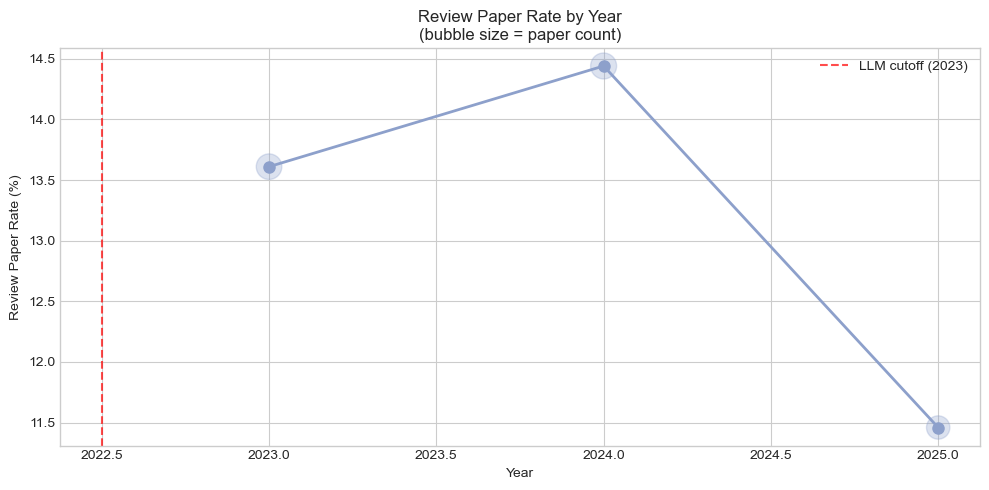

In [674]:
# Yearly trends
print("\n" + "="*60)
print("YEARLY REVIEW RATE TRENDS")
print("="*60)

yearly_stats = df_temporal.groupby('year').agg(
    unique_papers=('arxiv_id', 'nunique'),
    review_rate=('is_review', 'mean'),
).round(4)
yearly_stats['review_rate_pct'] = (yearly_stats['review_rate'] * 100).round(2)
print(yearly_stats)

# Visualize yearly trend
fig, ax = plt.subplots(figsize=(10, 5))
years = yearly_stats.index.values
rates = yearly_stats['review_rate_pct'].values
sizes = yearly_stats['unique_papers'].values
sizes_normalized = (sizes / sizes.max()) * 300 + 50

ax.plot(years, rates, 'o-', color='#8da0cb', linewidth=2, markersize=8)
ax.scatter(years, rates, s=sizes_normalized, alpha=0.3, color='#8da0cb')
ax.axvline(2022.5, color='red', linestyle='--', alpha=0.7, label='LLM cutoff (2023)')
ax.set_xlabel('Year')
ax.set_ylabel('Review Paper Rate (%)')
ax.set_title('Review Paper Rate by Year\n(bubble size = paper count)')
ax.legend()

plt.tight_layout()
plt.savefig('../figures/yearly_trend.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Category-Level Analysis

### Data and Sampling
This section uses `df_typed`, the full dataset of papers with assigned paper types (review vs. regular), grouped by CS subcategory. The analysis covers all 10 CS subcategories sampled for this study.

### Methodology
For each subcategory, we compute:
- **Unique Papers**: Total number of distinct papers in that category
- **Review Papers**: Count of papers classified as reviews
- **Review Rate**: Proportion of papers that are reviews

Results are sorted by review rate (descending) to identify which CS fields have the highest and lowest proportions of review papers.

### Output Files
- `../figures/review_rate_by_category.png`: Bar chart showing review rates across all CS subcategories with percentage labels

In [675]:
# Review rates by category
print("\n" + "="*60)
print("REVIEW PAPER RATES BY CS CATEGORY")
print("="*60)

category_stats = df_typed.groupby('category').agg(
    unique_papers=('arxiv_id', 'nunique'),
    review_papers=('is_review', lambda x: x.groupby(df_typed.loc[x.index, 'arxiv_id']).first().sum()),
    review_rate=('is_review', lambda x: x.groupby(df_typed.loc[x.index, 'arxiv_id']).first().mean()),
).round(4)
category_stats['review_rate_pct'] = (category_stats['review_rate'] * 100).round(2)
category_stats = category_stats.sort_values('review_rate', ascending=False)
print(category_stats)


REVIEW PAPER RATES BY CS CATEGORY
          unique_papers  review_papers  review_rate  review_rate_pct
category                                                            
cs-CY              1609            786       0.4885            48.85
cs-HC              2240            530       0.2366            23.66
cs-SE              2572            596       0.2317            23.17
cs-AI              2662            408       0.1533            15.33
cs-CR              2611            399       0.1528            15.28
cs-IR              1859            253       0.1361            13.61
cs-CL              2885            271       0.0939             9.39
cs-LG              2836            159       0.0561             5.61
cs-RO              2729             99       0.0363             3.63
cs-CV              2797             62       0.0222             2.22


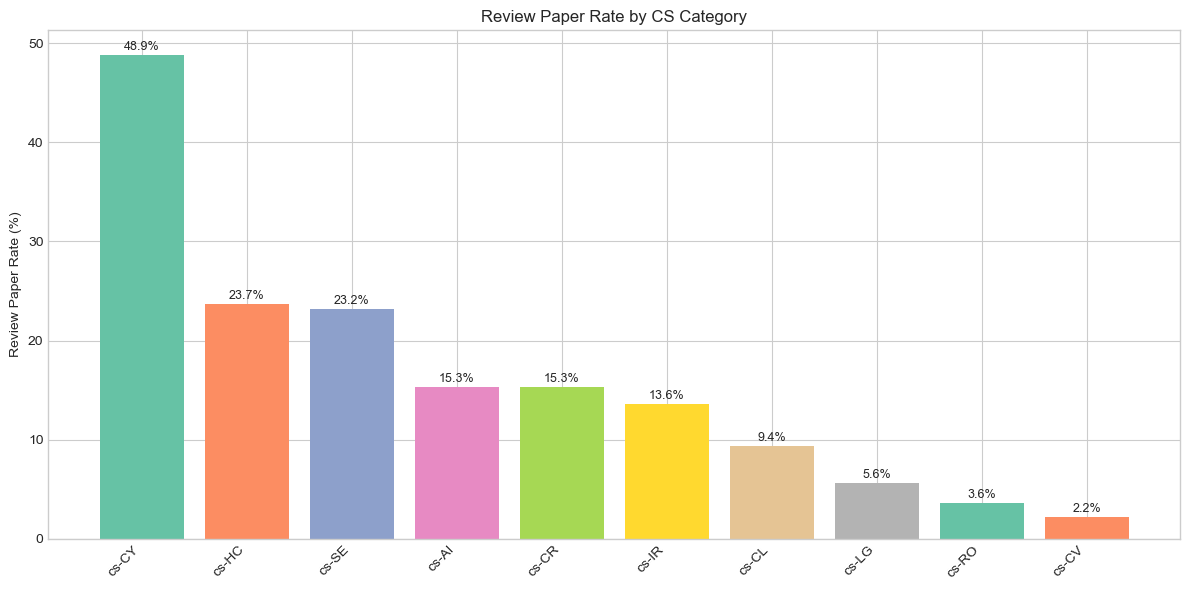

In [676]:
# Visualize category differences
fig, ax = plt.subplots(figsize=(12, 6))

# Filter to categories with data
cat_data = category_stats[category_stats['unique_papers'] > 100].copy()
colors = sns.color_palette('Set2', len(cat_data))

bars = ax.bar(range(len(cat_data)), cat_data['review_rate_pct'], color=colors)
ax.set_xticks(range(len(cat_data)))
ax.set_xticklabels(cat_data.index, rotation=45, ha='right')
ax.set_ylabel('Review Paper Rate (%)')
ax.set_title('Review Paper Rate by CS Category')

for bar, rate in zip(bars, cat_data['review_rate_pct']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{rate:.1f}%', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/review_rate_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Topic and Discipline Analysis

Examine which OpenAlex topics/disciplines are most affected by review paper policies.

### Data and Sampling
This section creates `topics_df` by extracting OpenAlex topic metadata from the works dataset. For each paper with known type ('review' or 'regular'), the following fields are extracted:
- `arxiv_id`: Paper identifier
- `paper_type` and `is_review`: Classification from AI detection or works data
- `primary_topic`, `primary_subfield`, `primary_field`: Primary OpenAlex topic hierarchy
- `num_topics`: Count of all topics assigned to the paper
- `all_subfields`, `all_fields`: Lists of all assigned subfields and fields

Papers with topic data: 25,103

### Methodology
**By Subfield Analysis:**
- Groups papers by `primary_subfield` (OpenAlex's mid-level topic classification)
- Filters to subfields with ≥100 papers for statistical reliability
- Calculates total papers, review papers, and review rate per subfield
- Results sorted by review rate to identify highest and lowest affected subfields

**By Field Analysis:**
- Groups papers by `primary_field` (OpenAlex's top-level discipline classification)
- Filters to fields with ≥50 papers
- Examines which broad disciplines have highest review paper concentrations

### Key Findings (from output)
- Highest review rate subfields: Safety Research (61.43%), Health Informatics (44.03%)
- Lowest review rate subfields: Biomedical Engineering (3.25%), Aerospace Engineering (3.98%)
- Highest review rate fields: Social Sciences (36.90%), Arts and Humanities (30.56%)
- Core Computer Science field: 12.57% review rate

### Output Files
- `../figures/subfield_rates_table.tex`: LaTeX table of subfield review rates
- `../figures/review_rate_by_field.png`: Horizontal bar chart showing review rates across OpenAlex fields

In [677]:
# Extract topic information from works
print("Extracting topic data from papers...")

paper_topics = []
for arxiv_id, work in works.items():
    # Get paper type from AI detection or works
    ai_info = ai_detection.get(arxiv_id, {})
    paper_type = ai_info.get('paper_type') or work.get('paper_type', 'unknown')
    
    # Get primary topic (may be None)
    primary = work.get('primary_topic') or {}
    
    # Get all topics
    topics = work.get('topics') or []
    
    paper_topics.append({
        'arxiv_id': arxiv_id,
        'paper_type': paper_type,
        'is_review': paper_type == 'review',
        'primary_topic': primary.get('name', ''),
        'primary_subfield': primary.get('subfield', ''),
        'primary_field': primary.get('field', ''),
        'num_topics': len(topics),
        'all_subfields': [t.get('subfield', '') for t in topics if t],
        'all_fields': [t.get('field', '') for t in topics if t],
    })

topics_df = pd.DataFrame(paper_topics)
topics_df = topics_df[topics_df['paper_type'].isin(['review', 'regular'])]
print(f"Papers with topic data: {len(topics_df):,}")

Extracting topic data from papers...
Papers with topic data: 25,103


In [678]:
# Review rates by primary subfield
print("\n" + "="*60)
print("REVIEW PAPER RATES BY OPENALEX SUBFIELD")
print("="*60)

subfield_stats = topics_df.groupby('primary_subfield').agg(
    total_papers=('arxiv_id', 'count'),
    review_papers=('is_review', 'sum'),
    review_rate=('is_review', 'mean'),
).round(4)
subfield_stats = subfield_stats[subfield_stats['total_papers'] >= 100]  # Filter small subfields
subfield_stats['review_rate_pct'] = (subfield_stats['review_rate'] * 100).round(2)
subfield_stats = subfield_stats.sort_values('review_rate', ascending=False)
print("Top 15 subfields by review rate:")
print(subfield_stats.head(15))
print("\nBottom 10 subfields by review rate:")
print(subfield_stats.tail(10))


REVIEW PAPER RATES BY OPENALEX SUBFIELD
Top 15 subfields by review rate:
                                               total_papers  review_papers  \
primary_subfield                                                             
Safety Research                                         280            172   
Health Informatics                                      159             70   
Sociology and Political Science                         420            136   
Management Information Systems                          249             80   
Education                                               113             35   
Political Science and International Relations           148             43   
Information Systems and Management                      205             57   
Computer Science Applications                           266             72   
Economics and Econometrics                              121             28   
Information Systems                                    2099         

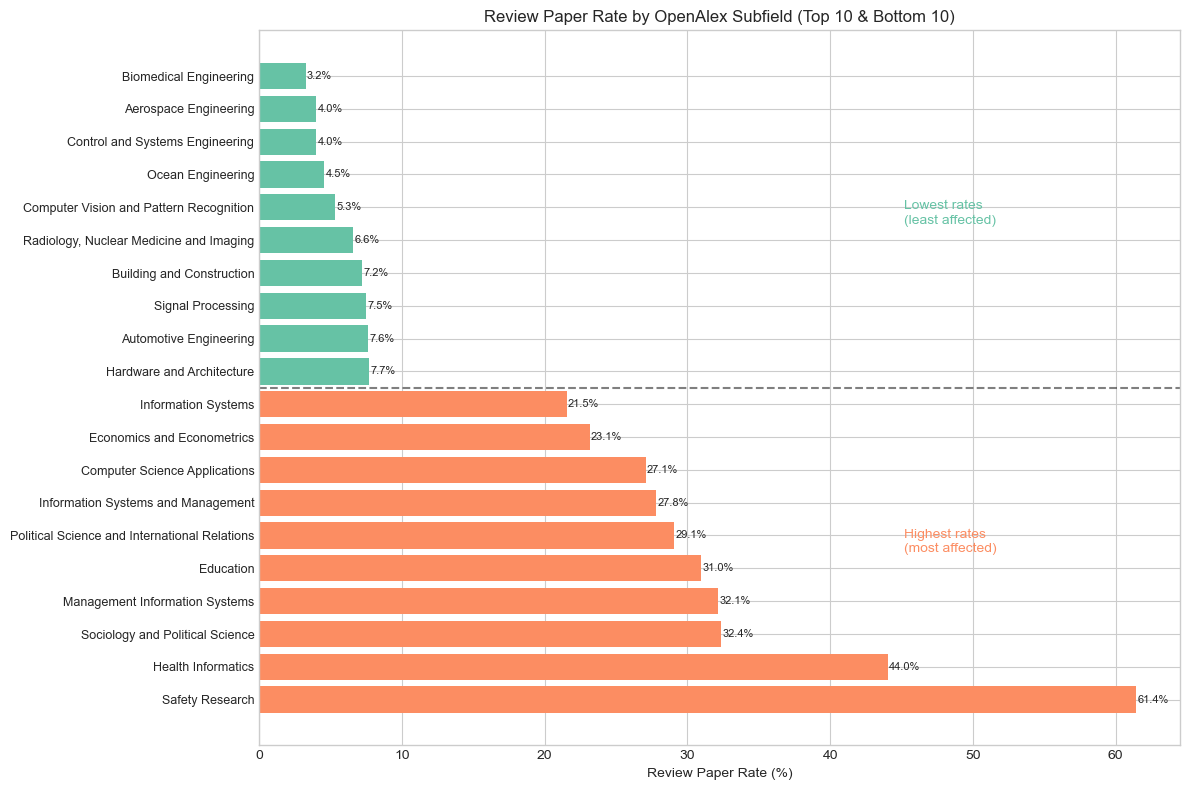

In [679]:
# Visualize top/bottom subfields
fig, ax = plt.subplots(figsize=(12, 8))

top_10 = subfield_stats.head(10)
bottom_10 = subfield_stats.tail(10)
plot_data = pd.concat([top_10, bottom_10])

y_pos = range(len(plot_data))
colors = ['#fc8d62' if i < 10 else '#66c2a5' for i in range(len(plot_data))]

bars = ax.barh(y_pos, plot_data['review_rate_pct'], color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_data.index, fontsize=9)
ax.set_xlabel('Review Paper Rate (%)')
ax.set_title('Review Paper Rate by OpenAlex Subfield (Top 10 & Bottom 10)')
ax.axhline(9.5, color='black', linestyle='--', alpha=0.5)
ax.text(ax.get_xlim()[1] * 0.7, 4.5, 'Highest rates\n(most affected)', fontsize=10, color='#fc8d62')
ax.text(ax.get_xlim()[1] * 0.7, 14.5, 'Lowest rates\n(least affected)', fontsize=10, color='#66c2a5')

for bar, rate in zip(bars, plot_data['review_rate_pct']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{rate:.1f}%', 
             va='center', fontsize=8)

plt.tight_layout()
plt.savefig('../figures/review_rate_by_subfield.pdf', bbox_inches='tight')
plt.show()

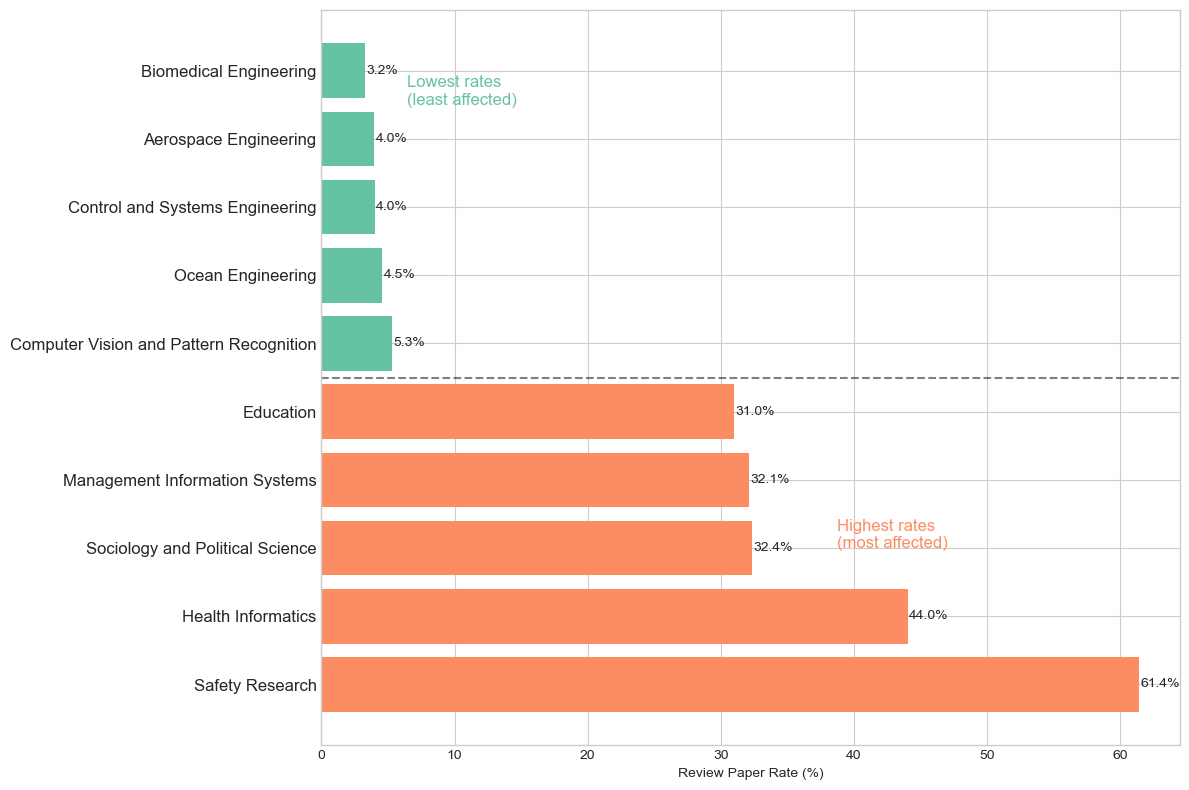

In [680]:
# Visualize top/bottom subfields
fig, ax = plt.subplots(figsize=(12, 8))

top_10 = subfield_stats.head(5)
bottom_10 = subfield_stats.tail(5)
plot_data = pd.concat([top_10, bottom_10])

y_pos = range(len(plot_data))
colors = ['#fc8d62' if i < 5 else '#66c2a5' for i in range(len(plot_data))]

bars = ax.barh(y_pos, plot_data['review_rate_pct'], color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_data.index, fontsize=12)
ax.set_xlabel('Review Paper Rate (%)')
# ax.set_title('Review Paper Rate by OpenAlex Subfield (Top 10 & Bottom 10)')
ax.axhline(4.5, color='black', linestyle='--', alpha=0.5)
ax.text(ax.get_xlim()[1] * 0.6, 2, 'Highest rates\n(most affected)', fontsize=12, color='#fc8d62')
ax.text(ax.get_xlim()[1] * 0.1, 8.5, 'Lowest rates\n(least affected)', fontsize=12, color='#66c2a5')

for bar, rate in zip(bars, plot_data['review_rate_pct']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{rate:.1f}%', 
             va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/review_rate_by_subfield.small.pdf', bbox_inches='tight')
plt.show()

In [681]:
# Generate LaTeX table for subfield analysis with cell shading
# Requires \\usepackage{xcolor} and \\usepackage{colortbl} in LaTeX preamble

def generate_shaded_latex_table(df, topic_col='index', rate_col='review_rate_pct', 
                                 color_base='blue', min_intensity=10, max_intensity=50):
    """
    Generate a LaTeX table with shaded cells based on rate values.
    Darker shades indicate higher percentages.
    
    Parameters:
    - df: DataFrame with topics and rates
    - topic_col: Column name for topics (or 'index' to use index)
    - rate_col: Column name for rates
    - color_base: Base color for shading (e.g., 'blue', 'gray')
    - min_intensity: Minimum color intensity (0-100)
    - max_intensity: Maximum color intensity (0-100)
    """
    # Get min and max rates for normalization
    min_rate = df[rate_col].min()
    max_rate = df[rate_col].max()
    
    # Build LaTeX table
    latex_lines = []
    latex_lines.append('% Requires: \\usepackage{xcolor} and \\usepackage{colortbl}')
    latex_lines.append('% Add to preamble: \\definecolor{tableblue}{RGB}{66, 133, 244}')
    latex_lines.append('')
    latex_lines.append('\\begin{table}[htbp]')
    latex_lines.append('\\centering')
    latex_lines.append('\\caption{Review Paper Rates by Subfield}')
    latex_lines.append('\\label{tab:subfield_rates}')
    latex_lines.append('\\begin{tabular}{lc}')
    latex_lines.append('\\toprule')
    latex_lines.append('\\textbf{Topic} & \\textbf{Rate (\\%)} \\\\')
    latex_lines.append('\\midrule')
    
    for idx, row in df.iterrows():
        topic = idx if topic_col == 'index' else row[topic_col]
        rate = row[rate_col]
        
        # Calculate intensity (higher rate = darker shade)
        if max_rate > min_rate:
            normalized = (rate - min_rate) / (max_rate - min_rate)
        else:
            normalized = 0.5
        intensity = int(min_intensity + normalized * (max_intensity - min_intensity))
        
        # Escape special LaTeX characters in topic name
        topic_escaped = topic.replace('&', '\\&').replace('_', '\\_').replace('%', '\\%')
        
        # Create row with cellcolor
        latex_lines.append(f'{topic_escaped} & \\cellcolor{{{color_base}!{intensity}}} {rate:.1f} \\\\')
    
    latex_lines.append('\\bottomrule')
    latex_lines.append('\\end{tabular}')
    latex_lines.append('\\end{table}')
    
    return '\n'.join(latex_lines)

# Generate table for top and bottom subfields
top_5 = subfield_stats.head(5)
bottom_5 = subfield_stats.tail(5)
combined_df = pd.concat([top_5, bottom_5])

# Generate LaTeX
latex_table = generate_shaded_latex_table(combined_df, rate_col='review_rate_pct')

# Save to file
with open('../figures/subfield_rates_table.tex', 'w') as f:
    f.write(latex_table)

print('LaTeX table saved to ../figures/subfield_rates_table.tex')
print()
print(latex_table)

LaTeX table saved to ../figures/subfield_rates_table.tex

% Requires: \usepackage{xcolor} and \usepackage{colortbl}
% Add to preamble: \definecolor{tableblue}{RGB}{66, 133, 244}

\begin{table}[htbp]
\centering
\caption{Review Paper Rates by Subfield}
\label{tab:subfield_rates}
\begin{tabular}{lc}
\toprule
\textbf{Topic} & \textbf{Rate (\%)} \\
\midrule
Safety Research & \cellcolor{blue!50} 61.4 \\
Health Informatics & \cellcolor{blue!38} 44.0 \\
Sociology and Political Science & \cellcolor{blue!30} 32.4 \\
Management Information Systems & \cellcolor{blue!29} 32.1 \\
Education & \cellcolor{blue!29} 31.0 \\
Computer Vision and Pattern Recognition & \cellcolor{blue!11} 5.3 \\
Ocean Engineering & \cellcolor{blue!10} 4.5 \\
Control and Systems Engineering & \cellcolor{blue!10} 4.0 \\
Aerospace Engineering & \cellcolor{blue!10} 4.0 \\
Biomedical Engineering & \cellcolor{blue!10} 3.2 \\
\bottomrule
\end{tabular}
\end{table}


In [682]:
# Generate LaTeX table with both review rate AND AI generation rate
# First, add AI detection data to topics_df

# Create AI detection lookup (ai_likelihood is stored directly in ai_detection dict)
ai_likelihood_dict = {}
for arxiv_id, info in ai_detection.items():
    # ai_likelihood is stored at top level, not in pangram_prediction
    ai_likelihood_dict[arxiv_id] = info.get('ai_likelihood')

# Add AI data to topics_df
topics_df['ai_likelihood'] = topics_df['arxiv_id'].map(ai_likelihood_dict)
topics_df['ai_flagged'] = topics_df['ai_likelihood'] > 0.5
topics_df['has_ai_detection'] = topics_df['ai_likelihood'].notna()

# Calculate subfield stats including AI rate
subfield_stats_with_ai = topics_df.groupby('primary_subfield').agg(
    total_papers=('arxiv_id', 'count'),
    review_papers=('is_review', 'sum'),
    review_rate=('is_review', 'mean'),
    ai_detected_papers=('has_ai_detection', 'sum'),
    ai_flagged_papers=('ai_flagged', 'sum'),
).round(4)

# Filter to subfields with sufficient data (100+ papers and 10+ with AI detection)
subfield_stats_with_ai = subfield_stats_with_ai[
    (subfield_stats_with_ai['total_papers'] >= 100) & 
    (subfield_stats_with_ai['ai_detected_papers'] >= 10)
]

# Calculate rates as percentages
subfield_stats_with_ai['review_rate_pct'] = (subfield_stats_with_ai['review_rate'] * 100).round(2)
subfield_stats_with_ai['ai_rate'] = (subfield_stats_with_ai['ai_flagged_papers'] / 
                                       subfield_stats_with_ai['ai_detected_papers']).round(4)
subfield_stats_with_ai['ai_rate_pct'] = (subfield_stats_with_ai['ai_rate'] * 100).round(2)
subfield_stats_with_ai = subfield_stats_with_ai.sort_values('review_rate', ascending=False)

print(f"Subfields with both review and AI data: {len(subfield_stats_with_ai)}")
print(subfield_stats_with_ai[['total_papers', 'review_rate_pct', 'ai_detected_papers', 'ai_rate_pct']].head(10))

Subfields with both review and AI data: 35
                                               total_papers  review_rate_pct  \
primary_subfield                                                               
Safety Research                                         280            61.43   
Health Informatics                                      159            44.03   
Sociology and Political Science                         420            32.38   
Management Information Systems                          249            32.13   
Education                                               113            30.97   
Political Science and International Relations           148            29.05   
Information Systems and Management                      205            27.80   
Computer Science Applications                           266            27.07   
Economics and Econometrics                              121            23.14   
Information Systems                                    2099            21.53 

In [683]:
# Generate two-column shaded LaTeX table (Review Rate + AI Rate)

def generate_two_rate_latex_table(df, topic_col='index', 
                                   rate1_col='review_rate_pct', rate1_label='Review Rate',
                                   rate2_col='ai_rate_pct', rate2_label='AI Rate',
                                   color1='blue', color2='red',
                                   min_intensity=10, max_intensity=50):
    """
    Generate a LaTeX table with two rate columns, each with shaded cells.
    """
    # Get min and max rates for normalization (per column)
    min_rate1, max_rate1 = df[rate1_col].min(), df[rate1_col].max()
    min_rate2, max_rate2 = df[rate2_col].min(), df[rate2_col].max()
    
    def calc_intensity(rate, min_rate, max_rate):
        if max_rate > min_rate:
            normalized = (rate - min_rate) / (max_rate - min_rate)
        else:
            normalized = 0.5
        return int(min_intensity + normalized * (max_intensity - min_intensity))
    
    # Build LaTeX table
    latex_lines = []
    latex_lines.append('% Requires: \\usepackage{xcolor} and \\usepackage{colortbl}')
    latex_lines.append('% Add to preamble: \\definecolor{tableblue}{RGB}{66, 133, 244}')
    latex_lines.append('% Add to preamble: \\definecolor{tablered}{RGB}{219, 68, 55}')
    latex_lines.append('')
    latex_lines.append('\\begin{table}[htbp]')
    latex_lines.append('\\centering')
    latex_lines.append('\\caption{Review Paper and AI Generation Rates by Subfield}')
    latex_lines.append('\\label{tab:subfield_rates_with_ai}')
    latex_lines.append('\\begin{tabular}{lcc}')
    latex_lines.append('\\toprule')
    latex_lines.append(f'\\textbf{{Topic}} & \\textbf{{{rate1_label} (\\%)}} & \\textbf{{{rate2_label} (\\%)}} \\\\')
    latex_lines.append('\\midrule')
    
    for idx, row in df.iterrows():
        topic = idx if topic_col == 'index' else row[topic_col]
        rate1 = row[rate1_col]
        rate2 = row[rate2_col]
        
        intensity1 = calc_intensity(rate1, min_rate1, max_rate1)
        intensity2 = calc_intensity(rate2, min_rate2, max_rate2)
        
        # Escape special LaTeX characters
        topic_escaped = topic.replace('&', '\\&').replace('_', '\\_').replace('%', '\\%')
        
        latex_lines.append(f'{topic_escaped} & \\cellcolor{{{color1}!{intensity1}}} {rate1:.1f} & \\cellcolor{{{color2}!{intensity2}}} {rate2:.1f} \\\\')
    
    latex_lines.append('\\bottomrule')
    latex_lines.append('\\end{tabular}')
    latex_lines.append('\\end{table}')
    
    return '\n'.join(latex_lines)

# Generate table for top and bottom subfields by review rate
top_5_ai = subfield_stats_with_ai.head(5)
bottom_5_ai = subfield_stats_with_ai.tail(5)
combined_df_ai = pd.concat([top_5_ai, bottom_5_ai])

# Generate LaTeX
latex_table_with_ai = generate_two_rate_latex_table(
    combined_df_ai, 
    rate1_col='review_rate_pct', rate1_label='Review Rate',
    rate2_col='ai_rate_pct', rate2_label='AI Rate'
)

# Save to file
with open('../figures/subfield_rates_with_ai_table.tex', 'w') as f:
    f.write(latex_table_with_ai)

print('LaTeX table saved to ../figures/subfield_rates_with_ai_table.tex')
print()
print(latex_table_with_ai)

LaTeX table saved to ../figures/subfield_rates_with_ai_table.tex

% Requires: \usepackage{xcolor} and \usepackage{colortbl}
% Add to preamble: \definecolor{tableblue}{RGB}{66, 133, 244}
% Add to preamble: \definecolor{tablered}{RGB}{219, 68, 55}

\begin{table}[htbp]
\centering
\caption{Review Paper and AI Generation Rates by Subfield}
\label{tab:subfield_rates_with_ai}
\begin{tabular}{lcc}
\toprule
\textbf{Topic} & \textbf{Review Rate (\%)} & \textbf{AI Rate (\%)} \\
\midrule
Safety Research & \cellcolor{blue!50} 61.4 & \cellcolor{red!33} 13.9 \\
Health Informatics & \cellcolor{blue!38} 44.0 & \cellcolor{red!50} 20.1 \\
Sociology and Political Science & \cellcolor{blue!30} 32.4 & \cellcolor{red!24} 10.7 \\
Management Information Systems & \cellcolor{blue!29} 32.1 & \cellcolor{red!43} 17.7 \\
Education & \cellcolor{blue!29} 31.0 & \cellcolor{red!31} 13.3 \\
Computer Vision and Pattern Recognition & \cellcolor{blue!11} 5.3 & \cellcolor{red!10} 5.2 \\
Ocean Engineering & \cellcolor{blue!1

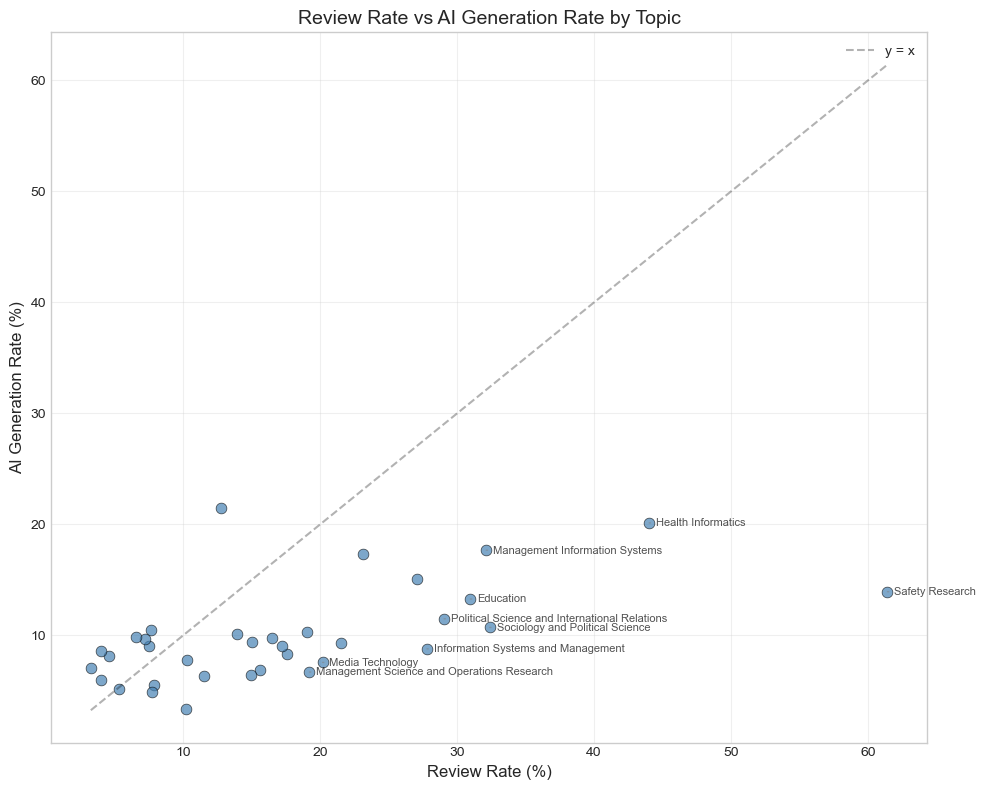

Scatter plot saved to ../figures/review_vs_ai_rate_scatter.png
Outlier threshold (75th percentile distance from diagonal): 8.76


In [684]:
# Scatter plot: Review Rate vs AI Generation Rate by Topic
import numpy as np

fig, ax = plt.subplots(figsize=(10, 8))

# Get data
x = subfield_stats_with_ai['review_rate_pct'].values
y = subfield_stats_with_ai['ai_rate_pct'].values
labels = subfield_stats_with_ai.index.tolist()

# Plot all points
ax.scatter(x, y, s=60, alpha=0.7, c='steelblue', edgecolors='black', linewidth=0.5)

# Add diagonal reference line (y=x)
max_val = max(max(x), max(y))
min_val = min(min(x), min(y))
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='y = x')

# Identify outliers: distance from diagonal (perpendicular distance from y=x line)
# For y=x line, perpendicular distance = |y - x| / sqrt(2)
distances = np.abs(y - x) / np.sqrt(2)
threshold = np.percentile(distances, 75)  # Label top 25% as outliers

# Label outliers
for i, label in enumerate(labels):
    if distances[i] >= threshold:
        # Offset text slightly to avoid overlap with point
        offset_x = -0.5 if y[i] > x[i] else 0.5
        offset_y = 0.3 if y[i] > x[i] else -0.3
        ax.annotate(label, (x[i], y[i]), 
                    xytext=(x[i] + offset_x, y[i] + offset_y),
                    fontsize=8, alpha=0.8,
                    arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5))

ax.set_xlabel('Review Rate (%)', fontsize=12)
ax.set_ylabel('AI Generation Rate (%)', fontsize=12)
ax.set_title('Review Rate vs AI Generation Rate by Topic', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/review_vs_ai_rate_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Scatter plot saved to ../figures/review_vs_ai_rate_scatter.png')
print(f'Outlier threshold (75th percentile distance from diagonal): {threshold:.2f}')

In [685]:
# Review rates by primary field (broader category)
print("\n" + "="*60)
print("REVIEW PAPER RATES BY OPENALEX FIELD")
print("="*60)

field_stats = topics_df.groupby('primary_field').agg(
    total_papers=('arxiv_id', 'count'),
    review_papers=('is_review', 'sum'),
    review_rate=('is_review', 'mean'),
).round(4)
field_stats = field_stats[field_stats['total_papers'] >= 50]
field_stats['review_rate_pct'] = (field_stats['review_rate'] * 100).round(2)
field_stats = field_stats.sort_values('review_rate', ascending=False)
print(field_stats)


REVIEW PAPER RATES BY OPENALEX FIELD
                                              total_papers  review_papers  \
primary_field                                                               
Social Sciences                                       1393            514   
Arts and Humanities                                    108             33   
Business, Management and Accounting                    425            124   
Economics, Econometrics and Finance                    147             40   
Health Professions                                     149             35   
Decision Sciences                                      609            137   
Medicine                                               551            113   
Psychology                                             508             98   
Neuroscience                                           277             45   
Environmental Science                                  153             20   
                                      

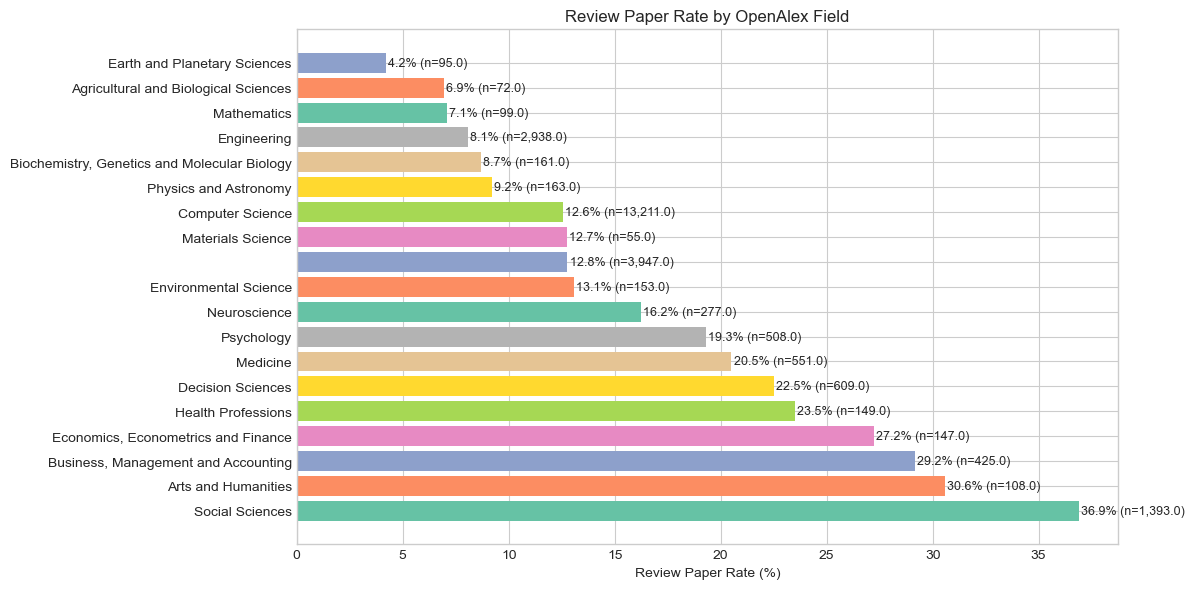

In [686]:
# Visualize field-level differences
fig, ax = plt.subplots(figsize=(12, 6))

colors = sns.color_palette('Set2', len(field_stats))
bars = ax.barh(range(len(field_stats)), field_stats['review_rate_pct'], color=colors)
ax.set_yticks(range(len(field_stats)))
ax.set_yticklabels(field_stats.index, fontsize=10)
ax.set_xlabel('Review Paper Rate (%)')
ax.set_title('Review Paper Rate by OpenAlex Field')

for bar, (idx, row) in zip(bars, field_stats.iterrows()):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{row["review_rate_pct"]:.1f}% (n={row["total_papers"]:,})', 
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/review_rate_by_field.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Interdisciplinarity Analysis

Examine whether interdisciplinary researchers (those who work across multiple fields/subfields) are more likely to write review papers.

### Data and Sampling
This section extends `topics_df` (25,103 papers with topic data) by computing interdisciplinarity metrics:
- `num_unique_subfields`: Count of distinct subfields assigned to each paper
- `num_unique_fields`: Count of distinct fields (top-level disciplines) assigned to each paper
- `is_interdisciplinary`: Binary flag for papers spanning 2+ fields

Papers with interdisciplinary classification (2+ fields): 9,011 (35.9%)

### Methodology
**Binary Interdisciplinarity Analysis:**
- Compares review rates between single-field papers (16,092) and interdisciplinary papers (9,011)
- Uses Chi-square test to assess statistical significance

**Continuous Interdisciplinarity Analysis:**
- Examines review rates across papers with 0, 1, 2, or 3 unique subfields
- Uses Spearman correlation to test for monotonic relationship between interdisciplinarity and review paper likelihood

**Author-Level Analysis:**
- Aggregates to unique authors (73,953 authors analyzed)
- Identifies authors working across 2+ subfields as 'interdisciplinary authors' (10,170 or 13.8%)

### Statistical Tests
- **Chi-square test** (interdisciplinary vs single-field): χ²=2.19, p=1.39e-01 (not significant)
- **Spearman correlation** (num_subfields vs is_review): r=-0.0108, p=8.74e-02 (not significant)

### Key Findings
- Single-field papers: 14.16% review rate
- Interdisciplinary papers: 14.85% review rate
- No statistically significant relationship between interdisciplinarity and review paper likelihood

### Output Files
- `../figures/review_rate_by_interdisciplinarity.png`: Two-panel figure showing (1) bar chart of single vs interdisciplinary review rates, (2) line plot of review rates by number of subfields with bubble sizes indicating sample sizes

In [687]:
# Calculate interdisciplinarity metrics for each paper
print("Calculating interdisciplinarity metrics...")

# Number of unique subfields and fields per paper
topics_df['num_unique_subfields'] = topics_df['all_subfields'].apply(lambda x: len(set([s for s in x if s])))
topics_df['num_unique_fields'] = topics_df['all_fields'].apply(lambda x: len(set([f for f in x if f])))

# Is interdisciplinary (spans multiple fields)
topics_df['is_interdisciplinary'] = topics_df['num_unique_fields'] > 1

print(f"Papers with interdisciplinary classification: {topics_df['is_interdisciplinary'].sum():,} ({100*topics_df['is_interdisciplinary'].mean():.1f}%)")
print(f"\nNumber of unique subfields per paper:")
print(topics_df['num_unique_subfields'].value_counts().sort_index())

Calculating interdisciplinarity metrics...
Papers with interdisciplinary classification: 9,011 (35.9%)

Number of unique subfields per paper:
num_unique_subfields
0    3947
1    6918
2    7832
3    6406
Name: count, dtype: int64


In [688]:
# Review rate by interdisciplinarity
print("\n" + "="*60)
print("REVIEW PAPER RATES BY INTERDISCIPLINARITY")
print("="*60)

# By binary interdisciplinary flag
interdisc_stats = topics_df.groupby('is_interdisciplinary').agg(
    total_papers=('arxiv_id', 'count'),
    review_papers=('is_review', 'sum'),
    review_rate=('is_review', 'mean'),
).round(4)
interdisc_stats.index = ['Single field', 'Interdisciplinary (2+ fields)']
interdisc_stats['review_rate_pct'] = (interdisc_stats['review_rate'] * 100).round(2)
print(interdisc_stats)

# Chi-square test
contingency = pd.crosstab(topics_df['is_interdisciplinary'], topics_df['is_review'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-square test: χ²={chi2:.2f}, p={p_value:.2e}")


REVIEW PAPER RATES BY INTERDISCIPLINARITY
                               total_papers  review_papers  review_rate  \
Single field                          16092           2278       0.1416   
Interdisciplinary (2+ fields)          9011           1338       0.1485   

                               review_rate_pct  
Single field                             14.16  
Interdisciplinary (2+ fields)            14.85  

Chi-square test: χ²=2.19, p=1.39e-01


In [689]:
# Review rate by number of subfields
print("\n" + "="*60)
print("REVIEW PAPER RATES BY NUMBER OF SUBFIELDS")
print("="*60)

subfield_count_stats = topics_df.groupby('num_unique_subfields').agg(
    total_papers=('arxiv_id', 'count'),
    review_papers=('is_review', 'sum'),
    review_rate=('is_review', 'mean'),
).round(4)
subfield_count_stats['review_rate_pct'] = (subfield_count_stats['review_rate'] * 100).round(2)
print(subfield_count_stats)

# Correlation test
corr, p_val = stats.spearmanr(topics_df['num_unique_subfields'], topics_df['is_review'])
print(f"\nSpearman correlation (num_subfields vs is_review): r={corr:.4f}, p={p_val:.2e}")


REVIEW PAPER RATES BY NUMBER OF SUBFIELDS
                      total_papers  review_papers  review_rate  \
num_unique_subfields                                             
0                             3947            504       0.1277   
1                             6918           1167       0.1687   
2                             7832           1055       0.1347   
3                             6406            890       0.1389   

                      review_rate_pct  
num_unique_subfields                   
0                               12.77  
1                               16.87  
2                               13.47  
3                               13.89  

Spearman correlation (num_subfields vs is_review): r=-0.0108, p=8.74e-02


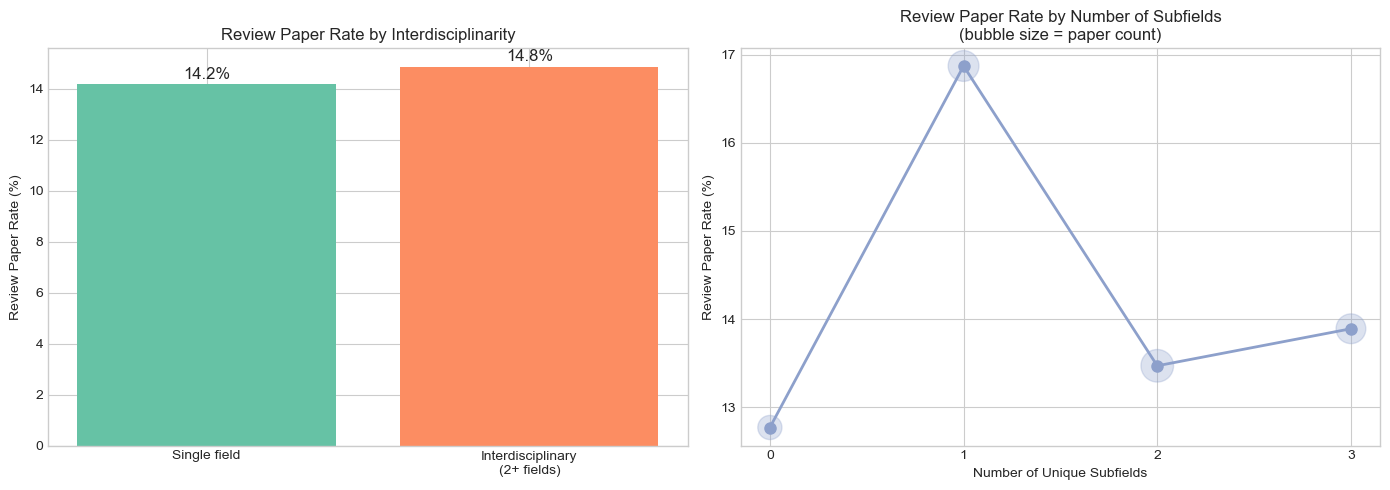

In [690]:
# Visualize interdisciplinarity effects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Single field vs Interdisciplinary
ax1 = axes[0]
rates = interdisc_stats['review_rate_pct'].values
bars = ax1.bar(['Single field', 'Interdisciplinary\n(2+ fields)'], rates, color=['#66c2a5', '#fc8d62'])
ax1.set_ylabel('Review Paper Rate (%)')
ax1.set_title('Review Paper Rate by Interdisciplinarity')
for bar, rate in zip(bars, rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{rate:.1f}%', 
             ha='center', va='bottom', fontsize=12)

# Line plot: Review rate by number of subfields
ax2 = axes[1]
x = subfield_count_stats.index.values
y = subfield_count_stats['review_rate_pct'].values
sizes = subfield_count_stats['total_papers'].values
sizes_normalized = (sizes / sizes.max()) * 500 + 50

ax2.plot(x, y, 'o-', color='#8da0cb', linewidth=2, markersize=8)
ax2.scatter(x, y, s=sizes_normalized, alpha=0.3, color='#8da0cb')
ax2.set_xlabel('Number of Unique Subfields')
ax2.set_ylabel('Review Paper Rate (%)')
ax2.set_title('Review Paper Rate by Number of Subfields\n(bubble size = paper count)')
ax2.set_xticks(x)

plt.tight_layout()
plt.savefig('../figures/review_rate_by_interdisciplinarity.png', dpi=150, bbox_inches='tight')
plt.show()

In [691]:
# Analyze author-level interdisciplinarity
print("\n" + "="*60)
print("AUTHOR-LEVEL INTERDISCIPLINARITY ANALYSIS")
print("="*60)

# For each author, calculate how many different subfields they publish in
author_subfields = defaultdict(set)
author_paper_types = defaultdict(list)

for arxiv_id, work in works.items():
    ai_info = ai_detection.get(arxiv_id, {})
    paper_type = ai_info.get('paper_type') or work.get('paper_type', 'unknown')
    if paper_type not in ['review', 'regular']:
        continue
    
    primary = work.get('primary_topic') or {}
    subfield = primary.get('subfield', '')
    
    for authorship in work.get('authorships', []):
        author_id = authorship.get('author_id', '')
        if author_id and subfield:
            author_subfields[author_id].add(subfield)
            author_paper_types[author_id].append(paper_type == 'review')

# Create author-level dataframe
author_interdisc = []
for author_id, subfields in author_subfields.items():
    paper_types = author_paper_types[author_id]
    author_interdisc.append({
        'author_id': author_id,
        'num_subfields': len(subfields),
        'num_papers': len(paper_types),
        'num_reviews': sum(paper_types),
        'has_review': any(paper_types),
    })

author_interdisc_df = pd.DataFrame(author_interdisc)
author_interdisc_df['is_interdisciplinary'] = author_interdisc_df['num_subfields'] > 1

print(f"Unique authors analyzed: {len(author_interdisc_df):,}")
print(f"Interdisciplinary authors (2+ subfields): {author_interdisc_df['is_interdisciplinary'].sum():,} ({100*author_interdisc_df['is_interdisciplinary'].mean():.1f}%)")


AUTHOR-LEVEL INTERDISCIPLINARITY ANALYSIS
Unique authors analyzed: 73,953
Interdisciplinary authors (2+ subfields): 10,170 (13.8%)


In [692]:
# Review paper rate by author interdisciplinarity
print("\n" + "="*60)
print("REVIEW PAPER AUTHORSHIP BY AUTHOR INTERDISCIPLINARITY")
print("="*60)

author_interdisc_stats = author_interdisc_df.groupby('is_interdisciplinary').agg(
    total_authors=('author_id', 'count'),
    authors_with_review=('has_review', 'sum'),
    review_author_rate=('has_review', 'mean'),
).round(4)
author_interdisc_stats.index = ['Single subfield', 'Interdisciplinary (2+ subfields)']
author_interdisc_stats['review_author_rate_pct'] = (author_interdisc_stats['review_author_rate'] * 100).round(2)
print(author_interdisc_stats)

# Chi-square test
contingency = pd.crosstab(author_interdisc_df['is_interdisciplinary'], author_interdisc_df['has_review'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-square test: χ²={chi2:.2f}, p={p_value:.2e}")


REVIEW PAPER AUTHORSHIP BY AUTHOR INTERDISCIPLINARITY
                                  total_authors  authors_with_review  \
Single subfield                           63783                 8531   
Interdisciplinary (2+ subfields)          10170                 3233   

                                  review_author_rate  review_author_rate_pct  
Single subfield                               0.1338                   13.38  
Interdisciplinary (2+ subfields)              0.3179                   31.79  

Chi-square test: χ²=2222.11, p=0.00e+00


In [693]:
# Review authorship rate by number of subfields
bins = [0, 1, 2, 3, 5, float('inf')]
labels = ['1 subfield', '2 subfields', '3 subfields', '4-5 subfields', '6+ subfields']
author_interdisc_df['subfield_bin'] = pd.cut(author_interdisc_df['num_subfields'], bins=bins, labels=labels)

author_subfield_stats = author_interdisc_df.groupby('subfield_bin').agg(
    total_authors=('author_id', 'count'),
    authors_with_review=('has_review', 'sum'),
    review_author_rate=('has_review', 'mean'),
).round(4)
author_subfield_stats['review_author_rate_pct'] = (author_subfield_stats['review_author_rate'] * 100).round(2)
print("\nReview authorship rate by number of subfields:")
print(author_subfield_stats)


Review authorship rate by number of subfields:
               total_authors  authors_with_review  review_author_rate  \
subfield_bin                                                            
1 subfield             63783                 8531              0.1338   
2 subfields             7466                 1971              0.2640   
3 subfields             1741                  685              0.3935   
4-5 subfields            787                  451              0.5731   
6+ subfields             176                  126              0.7159   

               review_author_rate_pct  
subfield_bin                           
1 subfield                      13.38  
2 subfields                     26.40  
3 subfields                     39.35  
4-5 subfields                   57.31  
6+ subfields                    71.59  


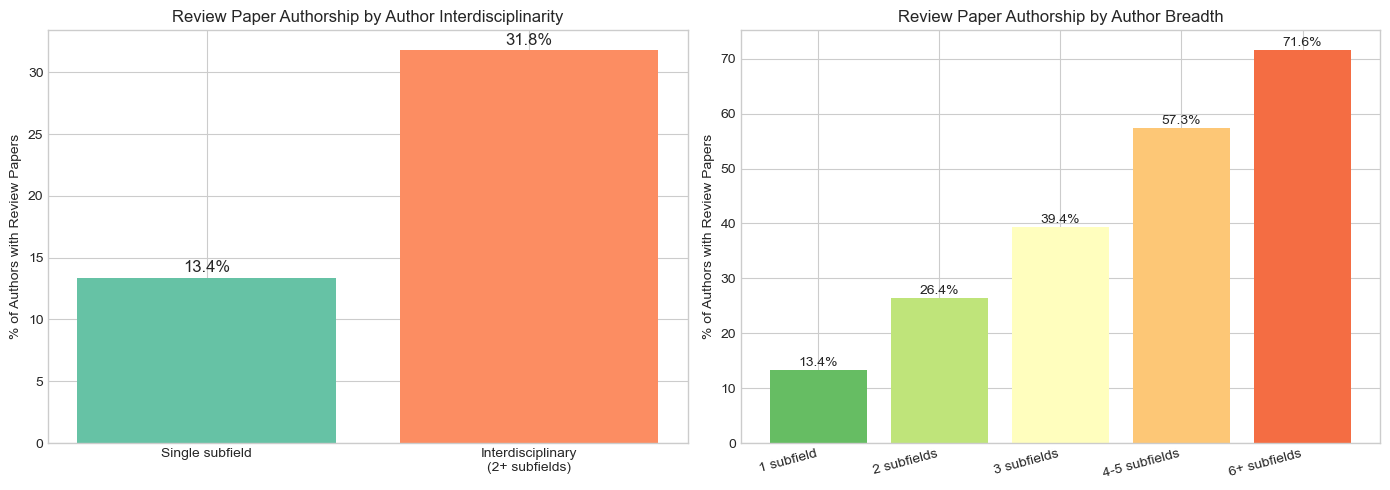

In [694]:
# Visualize author-level interdisciplinarity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Single vs interdisciplinary authors
ax1 = axes[0]
rates = author_interdisc_stats['review_author_rate_pct'].values
bars = ax1.bar(['Single subfield', 'Interdisciplinary\n(2+ subfields)'], rates, color=['#66c2a5', '#fc8d62'])
ax1.set_ylabel('% of Authors with Review Papers')
ax1.set_title('Review Paper Authorship by Author Interdisciplinarity')
for bar, rate in zip(bars, rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{rate:.1f}%', 
             ha='center', va='bottom', fontsize=12)

# By subfield bin
ax2 = axes[1]
x = range(len(author_subfield_stats))
y = author_subfield_stats['review_author_rate_pct'].values
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(y)))
bars = ax2.bar(x, y, color=colors)
ax2.set_xticks(x)
ax2.set_xticklabels(author_subfield_stats.index, rotation=15, ha='right')
ax2.set_ylabel('% of Authors with Review Papers')
ax2.set_title('Review Paper Authorship by Author Breadth')
for bar, rate in zip(bars, y):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{rate:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/review_rate_by_author_interdisciplinarity.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Impact Estimation

Estimate how many authors from each group would be affected by a review paper restriction.

In [695]:
# Calculate affected authors by group
print("\n" + "="*60)
print("ESTIMATED IMPACT: AUTHORS AFFECTED BY REVIEW PAPER RESTRICTION")
print("="*60)

# Unique authors who have written review papers
review_author_ids = df_typed[df_typed['is_review']]['author_id'].unique()
print(f"\nTotal unique authors with review papers: {len(review_author_ids):,}")

# Breakdown by seniority (using first occurrence of each author)
author_first = df_typed.groupby('author_id').first().reset_index()
review_authors = author_first[author_first['author_id'].isin(review_author_ids)]

print("\nAffected authors by seniority:")
print(review_authors['seniority'].value_counts())

print("\nAffected authors from Global South:")
gs_review = review_authors[review_authors['is_global_south']]
print(f"  {len(gs_review):,} authors ({100*len(gs_review)/len(review_authors):.1f}% of affected)")


ESTIMATED IMPACT: AUTHORS AFFECTED BY REVIEW PAPER RESTRICTION

Total unique authors with review papers: 13,128

Affected authors by seniority:
seniority
Junior (h≤5)           5125
Mid-career (h 6-15)    3540
Senior (h 16-30)       2551
Very Senior (h>30)     1912
Name: count, dtype: int64

Affected authors from Global South:
  24 authors (0.2% of affected)


In [696]:
# Relative risk calculation
print("\n" + "="*60)
print("RELATIVE RISK ANALYSIS")
print("="*60)

# For each group, calculate the relative risk of writing a review paper
# compared to the baseline (most advantaged group)

# Baseline: Senior + High Prestige + Global North
baseline = df_intersect[
    (~df_intersect['is_junior']) & 
    (~df_intersect['is_low_prestige']) & 
    (~df_intersect['is_global_south'])
]['is_review'].mean()

print(f"Baseline review rate (Senior + High Prestige + Global North): {baseline*100:.2f}%")
print("\nRelative risk by group:")

groups = {
    'Junior authors (h≤5)': df_intersect[df_intersect['is_junior']],
    'Low prestige institutions (h≤100)': df_intersect[df_intersect['is_low_prestige']],
    'Global South': df_intersect[df_intersect['is_global_south']],
    'Junior + Low Prestige': df_intersect[df_intersect['is_junior'] & df_intersect['is_low_prestige']],
    'Junior + Global South': df_intersect[df_intersect['is_junior'] & df_intersect['is_global_south']],
    'All 3 disadvantaged': df_intersect[df_intersect['disadvantage_count'] == 3],
}

for name, group in groups.items():
    rate = group['is_review'].mean()
    rr = rate / baseline if baseline > 0 else float('inf')
    print(f"  {name}: {rate*100:.2f}% (RR = {rr:.2f}x)")


RELATIVE RISK ANALYSIS
Baseline review rate (Senior + High Prestige + Global North): 21.79%

Relative risk by group:
  Junior authors (h≤5): 18.36% (RR = 0.84x)
  Low prestige institutions (h≤100): 14.92% (RR = 0.68x)
  Global South: 8.89% (RR = 0.41x)
  Junior + Low Prestige: 13.22% (RR = 0.61x)
  Junior + Global South: 7.78% (RR = 0.36x)
  All 3 disadvantaged: 15.38% (RR = 0.71x)


## 11. Summary and Key Findings

In [697]:
print("\n" + "="*70)
print("SUMMARY: KEY FINDINGS")
print("="*70)

print("\n1. REVIEW PAPER AUTHORSHIP PATTERNS:")
print("-" * 50)

# H-index comparison
review_h_median = df_typed[df_typed['is_review']]['author_h_index'].median()
regular_h_median = df_typed[~df_typed['is_review']]['author_h_index'].median()
print(f"   • Median h-index: Review={review_h_median:.1f} vs Regular={regular_h_median:.1f}")

# Junior researcher impact
junior_review_rate = df_typed[df_typed['author_h_index'] <= 5]['is_review'].mean()
senior_review_rate = df_typed[df_typed['author_h_index'] > 30]['is_review'].mean()
print(f"   • Junior (h≤5) review rate: {junior_review_rate*100:.2f}%")
print(f"   • Very senior (h>30) review rate: {senior_review_rate*100:.2f}%")

# Global South
if len(df_with_country) > 0:
    gs_rate = df_with_country[df_with_country['is_global_south']]['is_review'].mean()
    gn_rate = df_with_country[~df_with_country['is_global_south']]['is_review'].mean()
    print(f"   • Global South review rate: {gs_rate*100:.2f}%")
    print(f"   • Global North review rate: {gn_rate*100:.2f}%")

print("\n2. AI DETECTION PATTERNS:")
print("-" * 50)
if len(df_ai) > 0:
    overall_flag_rate = df_ai['ai_flagged'].mean()
    print(f"   • Overall AI flag rate (>50%): {overall_flag_rate*100:.3f}%")
    print(f"   • Mean AI likelihood: {df_ai['ai_likelihood'].mean()*100:.4f}%")

print("\n3. TOPIC/DISCIPLINE EFFECTS:")
print("-" * 50)
if len(subfield_stats) > 0:
    top_subfield = subfield_stats.index[0]
    top_rate = subfield_stats.iloc[0]['review_rate_pct']
    bottom_subfield = subfield_stats.index[-1]
    bottom_rate = subfield_stats.iloc[-1]['review_rate_pct']
    print(f"   • Highest review rate subfield: {top_subfield} ({top_rate:.1f}%)")
    print(f"   • Lowest review rate subfield: {bottom_subfield} ({bottom_rate:.1f}%)")

print("\n4. INTERDISCIPLINARITY EFFECTS:")
print("-" * 50)
if len(interdisc_stats) > 0:
    single_rate = interdisc_stats.loc['Single field', 'review_rate_pct']
    multi_rate = interdisc_stats.loc['Interdisciplinary (2+ fields)', 'review_rate_pct']
    print(f"   • Single-field papers review rate: {single_rate:.2f}%")
    print(f"   • Interdisciplinary papers review rate: {multi_rate:.2f}%")
if len(author_interdisc_stats) > 0:
    single_auth = author_interdisc_stats.loc['Single subfield', 'review_author_rate_pct']
    multi_auth = author_interdisc_stats.loc['Interdisciplinary (2+ subfields)', 'review_author_rate_pct']
    print(f"   • Single-subfield authors with reviews: {single_auth:.1f}%")
    print(f"   • Interdisciplinary authors with reviews: {multi_auth:.1f}%")

print("\n5. TEMPORAL PATTERNS (PRE vs POST-LLM):")
print("-" * 50)
pre_rate = None
post_rate = None
if 'Pre-LLM (2020-2022)' in period_stats.index:
    pre_rate = period_stats.loc['Pre-LLM (2020-2022)', 'review_rate_pct']
    print(f"   • Pre-LLM (2020-2022) review rate: {pre_rate:.2f}%")
if 'Post-LLM (2023+)' in period_stats.index:
    post_rate = period_stats.loc['Post-LLM (2023+)', 'review_rate_pct']
    print(f"   • Post-LLM (2023+) review rate: {post_rate:.2f}%")
if pre_rate is not None and post_rate is not None:
    print(f"   • Change: {post_rate - pre_rate:+.2f} percentage points")
elif len(period_stats) == 1:
    print(f"   • Only one period present in data")

print("\n6. INTERSECTIONAL EFFECTS:")
print("-" * 50)
print(f"   • Most disadvantaged group (Junior + Low Prestige + Global South):")
most_disadv = df_intersect[df_intersect['disadvantage_count'] == 3]
if len(most_disadv) > 0:
    print(f"     Review rate: {most_disadv['is_review'].mean()*100:.2f}%")
    print(f"     N = {len(most_disadv):,} author-paper instances")

print("\n7. POLICY IMPLICATIONS:")
print("-" * 50)
total_review_papers = df_typed[df_typed['is_review']]['arxiv_id'].nunique()
total_affected_authors = len(review_author_ids)
print(f"   • Total review papers that would be affected: {total_review_papers:,}")
print(f"   • Total unique authors affected: {total_affected_authors:,}")


SUMMARY: KEY FINDINGS

1. REVIEW PAPER AUTHORSHIP PATTERNS:
--------------------------------------------------
   • Median h-index: Review=10.0 vs Regular=10.0
   • Junior (h≤5) review rate: 13.36%
   • Very senior (h>30) review rate: 13.00%
   • Global South review rate: 8.89%
   • Global North review rate: 20.77%

2. AI DETECTION PATTERNS:
--------------------------------------------------
   • Overall AI flag rate (>50%): 8.646%
   • Mean AI likelihood: 9.3454%

3. TOPIC/DISCIPLINE EFFECTS:
--------------------------------------------------
   • Highest review rate subfield: Safety Research (61.4%)
   • Lowest review rate subfield: Biomedical Engineering (3.2%)

4. INTERDISCIPLINARITY EFFECTS:
--------------------------------------------------
   • Single-field papers review rate: 14.16%
   • Interdisciplinary papers review rate: 14.85%
   • Single-subfield authors with reviews: 13.4%
   • Interdisciplinary authors with reviews: 31.8%

5. TEMPORAL PATTERNS (PRE vs POST-LLM):
------

In [698]:
# Save summary statistics to CSV
summary_data = {
    'Metric': [
        'Total papers analyzed',
        'Review papers',
        'Regular papers',
        'Total author-paper instances',
        'Unique authors',
        'Authors affected by review restriction',
        'Median h-index (review authors)',
        'Median h-index (regular authors)',
        'Junior author review rate',
        'Senior author review rate',
        'Global South review rate',
        'Global North review rate',
        'Highest review rate subfield',
        'Lowest review rate subfield',
        'Single-field paper review rate',
        'Interdisciplinary paper review rate',
        'Single-subfield author review rate',
        'Interdisciplinary author review rate',
        'Pre-LLM review rate',
        'Post-LLM review rate',
        'Temporal change (pp)',
    ],
    'Value': [
        df_typed['arxiv_id'].nunique(),
        df_typed[df_typed['is_review']]['arxiv_id'].nunique(),
        df_typed[~df_typed['is_review']]['arxiv_id'].nunique(),
        len(df_typed),
        df_typed['author_id'].nunique(),
        len(review_author_ids),
        review_h_median,
        regular_h_median,
        f"{junior_review_rate*100:.2f}%",
        f"{senior_review_rate*100:.2f}%",
        f"{gs_rate*100:.2f}%" if len(df_with_country) > 0 else 'N/A',
        f"{gn_rate*100:.2f}%" if len(df_with_country) > 0 else 'N/A',
        f"{top_subfield} ({top_rate:.1f}%)" if len(subfield_stats) > 0 else 'N/A',
        f"{bottom_subfield} ({bottom_rate:.1f}%)" if len(subfield_stats) > 0 else 'N/A',
        f"{single_rate:.2f}%" if len(interdisc_stats) > 0 else 'N/A',
        f"{multi_rate:.2f}%" if len(interdisc_stats) > 0 else 'N/A',
        f"{single_auth:.1f}%" if len(author_interdisc_stats) > 0 else 'N/A',
        f"{multi_auth:.1f}%" if len(author_interdisc_stats) > 0 else 'N/A',
        f"{pre_rate:.2f}%" if pre_rate is not None else 'N/A',
        f"{post_rate:.2f}%" if post_rate is not None else 'N/A',
        f"{post_rate - pre_rate:+.2f}" if (pre_rate is not None and post_rate is not None) else 'N/A',
    ]
}
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('../data/results/policy_impact_summary.csv', index=False)
print("\nSummary saved to ../data/results/policy_impact_summary.csv")


Summary saved to ../data/results/policy_impact_summary.csv
